# Note: This is a duplicate of notebook 24 with paper ready printing

# NOTE: This is now implemented in ../trajectories/optimized_spherical_paths.py


In [7]:
### FOR INLINE PLOTS RUN THIS. 

%matplotlib inline

### THE CELL BELOW WILL HAVE NO EFFECT IF YOU RUN THIS.

In [ ]:
### FOR INTERACTIVE PLOTS RUN THIS
### IF YOU RUN THIS FIRST, THE CELL ABOVE WILL HAVE NO EFFECT UNTIL YOU RESTART THIS KERNEL

%matplotlib notebook



In [13]:
%load_ext autoreload
%autoreload 2

import time

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy.sparse as sp
import numpy.linalg as la

from scipy import interpolate
from scipy.special import expit

from optimize.snopt7 import SNOPT_solver

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims


def slerp(p0, p1, t):
    omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
    so = np.sin(omega)
    return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def fovX_from_fovY(fovY, aspect):
    tanY = np.tan(fovY / 2.0)
    tanX = tanY * aspect;
    fovX = np.arctan(tanX)
    return fovX

def vector3_to_str(v):
    return "(%.2f, %.2f, %.2f)" % (v.x(), v.y(), v.z())

def quaternion_to_str(q):
    return "(w,x,y,z): (%.2f, %.2f, %.2f, %.2f)" % (q.w(), q.x(), q.y(), q.z())

    
def drawSetup(subfig, A, B, C0, C1, min_dist, fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    subfig.set_aspect('equal')
    fig = subfig
    
    # Set up plot size
    subfig.set_xlim((np.min([A[0], B[0], C0[0], C1[0]])-fudgeX,np.max([A[0], B[0], C0[0], C1[0]])+fudgeX))
    subfig.set_ylim((np.min([A[1], B[1], C0[1], C1[1]])-fudgeY_neg,np.max([A[1], B[1], C0[1], C1[1]])+fudgeY_pos))

    # Draw People Positions
    subfig.scatter([A[0], B[0]],[A[1], B[1]],c="red",linewidths=0)
    line_AB = plt.Line2D([A[0], B[0]],[A[1], B[1]], c="black",alpha=0.3)
    subfig.add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle(A,min_dist,color='g',alpha=0.3)
    circle_PB_1=plt.Circle(B,min_dist,color='g',alpha=0.3)
    
    subfig.add_artist(circle_PA_1)
    subfig.add_artist(circle_PB_1)

    subfig.annotate(s="A", xy=A[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="B", xy=B[0:2],xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    subfig.scatter([C0[0],C1[0]],[C0[1],C1[1]],c="blue",linewidths=0)
    subfig.annotate(s="C0", xy=C0[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="C1", xy=C1[0:2],xytext=(3,4),textcoords="offset points")

def drawWorldTrajectoryGivenSubfigures(fig_traj, fig_blend, people, camera, position_trajectories, params):
    sigmaBlended, wA, sigmaAvg, sigmaA, sigmaB = position_trajectories

    A, B = people
    C0, C1 = camera
    min_dist = params['min_dist']
    
    # Drawing Code
    f1 = fig_traj
    f2 = fig_blend

    drawSetup(f1, A, B, C0, C1, min_dist,fudgeY_neg=(4+min_dist),fudgeY_pos=(3+min_dist),fudgeX=min_dist+0.5)
    f1.plot(sigmaA[:,0],       sigmaA[:,1],       c="green")
    f1.plot(sigmaB[:,0],       sigmaB[:,1],       c="blue")
    f1.plot(sigmaAvg[:,0],     sigmaAvg[:,1],     c="red")
    f1.plot(sigmaBlended[:,0], sigmaBlended[:,1], c="purple")

    f1.set_title("World Space Trajectories")

    sA_legend = mpatches.Patch(color="green", label="sigmaA")
    sB_legend = mpatches.Patch(color="blue", label="sigmaB")
    SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
    SW_legend  = mpatches.Patch(color="purple", label="sigma Optimized")

    f1.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])


    f2.set_aspect(1/2.)
    f2.set_xlim(0,1)
    f2.set_ylim(-0.1,1.1)
    f2.plot(np.linspace(0,1), wA)
    f2.set_title("Weighing function")    

def drawWorldTrajectory(people, camera, position_trajectories, params):
    pylab.rcParams['figure.figsize'] = 20, 8
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 
    fig = plt.figure()
    f1 = fig.add_subplot(gs[0])
    f2 = fig.add_subplot(gs[1])
    
    drawWorldTrajectoryGivenSubfigures(f1, f2, people, camera, position_trajectories, params)

def drawScreenSpaceTrajectoryGivenSubfigure(fig, screenspace, screen_trajectories, params):
    S0 , S1 = screenspace
    SA0, SB0 = S0
    SA1, SB1 = S1
    
    SA_actual, SB_actual, SA_des, SB_des = screen_trajectories
    scaleX = params['aspect']
    
    fig.set_aspect(1/scaleX)
    
    
    # Set up plot size
    fig.set_xlim(-1, 1)
    fig.set_ylim(-1, 1)
    
    # Draw rule of thirds
    line_l = plt.Line2D([-0.33, -0.33],[-1, 1], c="black",alpha=0.3)
    line_r = plt.Line2D([0.33, 0.33],[-1, 1], c="black",alpha=0.3)
    line_b = plt.Line2D([-1, 1],[-0.33, -0.33], c="black",alpha=0.3)
    line_t = plt.Line2D([-1, 1],[0.33, 0.33], c="black",alpha=0.3)
    fig.add_artist(line_l)
    fig.add_artist(line_r)
    fig.add_artist(line_b)
    fig.add_artist(line_t)
    
    # Draw new interpolated positions
    #plt.scatter(SA_x_lin,SA_y_lin,cmap='copper',linewidths=0)
    #plt.scatter(SB_x_lin,SB_y_lin,cmap='copper',linewidths=0)
    
    # Draw A screen positions
    fig.scatter([SA0[0], SA1[0]],[SA0[1], SA1[1]],c="red",linewidths=0)
    line_A = plt.Line2D([SA0[0], SA1[0]],[SA0[1], SA1[1]], c="black",alpha=0.3)
    fig.annotate(s="SA1", xy=(SA0[0], SA0[1]),xytext=(3,4),textcoords="offset points")
    fig.annotate(s="SA2", xy=(SA1[0], SA1[1]),xytext=(3,4),textcoords="offset points")
    fig.add_artist(line_A)
    
    # Draw B screen positions
    fig.scatter([SB0[0], SB1[0]],[SB0[1], SB1[1]],c="red",linewidths=0)
    line_B = plt.Line2D([SB0[0], SB1[0]],[SB0[1], SB1[1]], c="black",alpha=0.3)
    fig.annotate(s="SB1", xy=(SB0[0], SB0[1]),xytext=(3,4),textcoords="offset points")
    fig.annotate(s="SB2", xy=(SB1[0], SB1[1]),xytext=(3,4),textcoords="offset points")
    fig.add_artist(line_B)

    
    scattersize = 4
    # Draw lerped screen space
    plt.scatter(SA_des[:,0],SA_des[:,1],cmap='copper',linewidths=0, s=scattersize)
    plt.scatter(SB_des[:,0],SB_des[:,1],cmap='copper',linewidths=0, s=scattersize)
    
    # Draw actual screen space path for person A
    plt.scatter(SA_actual[:,0],SA_actual[:,1],c="green",linewidths=0, s=scattersize)
    #plt.annotate(s="SA1_new", xy=(SA_1_new.x(), SA_1_new.y()),xytext=(3,-10),textcoords="offset points")
    #plt.annotate(s="SA2_new", xy=(SA_2_new.x(), SA_2_new.y()),xytext=(3,-10),textcoords="offset points")
    
    # Draw actual screen space path for person B
    plt.scatter(SB_actual[:,0],SB_actual[:,1],c="green",linewidths=0, s=scattersize)
    #plt.annotate(s="SB1_new", xy=(SB_1_new.x(), SB_1_new.y()),xytext=(3,-10),textcoords="offset points")
    #plt.annotate(s="SB2_new", xy=(SB_2_new.x(), SB_2_new.y()),xytext=(3,-10),textcoords="offset points")
    
def drawScreenSpaceTrajectory(screenspace, screen_trajectories, params):
    
    pylab.rcParams['figure.figsize'] = 9, 16
    gs = gridspec.GridSpec(1, 1, width_ratios=[1], height_ratios=[1]) 
    fig = plt.figure()
    f1 = fig.add_subplot(gs[0])
    
    drawScreenSpaceTrajectoryGivenSubfigure(f1, screenspace, screen_trajectories, params)
    
def drawWorldAndScreenSpaceTrajectories(people, camera, screenspace, position_trajectories, screen_trajectories, params):
    pylab.rcParams['figure.figsize'] = 20, 8
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 2], height_ratios=[1]) 
    fig = plt.figure()
    
    if 'figtitle' in params:
        fig.suptitle(params['figtitle'], fontsize=18)
    
    f1 = fig.add_subplot(gs[0])
    f2 = fig.add_subplot(gs[1])
    f3 = fig.add_subplot(gs[2])
    
    drawWorldTrajectoryGivenSubfigures(f1, f2, people, camera, position_trajectories, params)
    drawScreenSpaceTrajectoryGivenSubfigure(f3, screenspace, screen_trajectories, params)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def calculate_position_trajectory_as_optimized_blend(A, B, C0, C1, blendOptimizer, params):
    '''
    This function sets up the problem, and passes in the individual trajectories
    to the given blendOptimizer function. 
    
    blendOptimizer must return a blended trajectory as well as a blending function.
    
    Returns:
    All the trajectories it calculates
    
    '''
    nsamples = params['nsamples']
    min_dist = params['min_dist']
    
    # Set up interpolation vector
    u = np.c_[np.linspace(0,1,num=nsamples)]

    # Set up the distance components of sigmaA, sigmaB
    dA0 = la.norm(C0 - A)
    dA1 = la.norm(C1 - A)
    dB0 = la.norm(C0 - B)
    dB1 = la.norm(C1 - B)

    dA = np.linspace(dA0, dA1,num=nsamples)
    dB = np.linspace(dB0, dB1,num=nsamples)

    # Set up the vantage vector components of sigmaA, sigmaB
    vA0 = (C0 - A) / dA0
    vA1 = (C1 - A) / dA1
    vB0 = (C0 - B) / dB0
    vB1 = (C1 - B) / dB1

    vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
    vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

    # Set up sigmaA, sigmaB, sigma
    sigmaA = A + dA[:,np.newaxis] * vA
    sigmaB = B + dB[:,np.newaxis] * vB

    sigmaAvg = (sigmaA + sigmaB)/2
    wA, sigmaBlended = blendOptimizer(u, sigmaA, sigmaB, A, B, min_dist, min_dist, params)

    return sigmaBlended, wA, sigmaAvg, sigmaA, sigmaB 

def optimize_blending_function_between_two_distance_sigmas(sigmaA, sigmaB, personA, personB, min_distA, min_distB, params, constrain_at_endpoints=False):
    # Some important parameters here
    nsamples = params['nsamples']
    ndims    = 6
    
    dt = 0.01
    xdot5_limit = 0.001

    inf = 1.0e20

    lambda_snap = 1#(1/dt)**4 # snap must be scaled down to be comparable to position.
    lambda_pos = 1

    # A few derived quantities
    nvars = ndims*nsamples
    nconstraints_continuity = (ndims-1)*nsamples
    nconstraints_obstacles = 2*nsamples
    nconstraints = 1 + nconstraints_continuity + nconstraints_obstacles

    # Solver configuration
    snopt = SNOPT_solver()
    snopt.setOption('Verbose',False)
    snopt.setOption('Solution print',False)
    snopt.setOption('Print file','test5.out')
    snopt.setOption('Iteration limit',8000)
    snopt.setOption('Print level',3)
    snopt.setOption('Major optimality',2e-6)
    snopt.setOption('Verify level',3) # Turn to 3 to carefully check gradiants


    # 1. Set up decision variables
    x     = np.array([0.5]*nsamples) # Initialize to 0.5
    xdot1 = np.array([0.0]*nsamples)
    xdot2 = np.array([0.0]*nsamples)
    xdot3 = np.array([0.0]*nsamples)
    xdot4 = np.array([0.0]*nsamples)
    v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

    x0 = np.matrix(np.c_[x,xdot1,xdot2,xdot3,xdot4,v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

    # 2. Set up the bounds on x
    low_x     = np.array([ 0.0] *nsamples) # X must be greater or equal to 0
    low_xdot1 = np.array([ -inf]*nsamples)
    low_xdot2 = np.array([ -inf]*nsamples)
    low_xdot3 = np.array([ -inf]*nsamples)
    low_xdot4 = np.array([ -inf]*nsamples)
    low_v     = np.array([ -xdot5_limit]*nsamples) # Bound control variable arbitrarily
    if constrain_at_endpoints:
        low_x[0] = 0.5
        low_x[nsamples-1] = 0.5    
    xlow = np.matrix(np.c_[low_x,low_xdot1,low_xdot2,low_xdot3,low_xdot4,low_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

    upp_x     = np.array([ 1.0] *nsamples) # X must be greater or equal to 0
    upp_xdot1 = np.array([ inf]*nsamples)
    upp_xdot2 = np.array([ inf]*nsamples)
    upp_xdot3 = np.array([ inf]*nsamples)
    upp_xdot4 = np.array([ inf]*nsamples)
    upp_v     = np.array([ xdot5_limit]*nsamples) # Bound control variable arbitrarily
    if constrain_at_endpoints:
        upp_x[0] = 0.5
        upp_x[nsamples-1] = 0.5
    xupp = np.matrix(np.c_[upp_x,upp_xdot1,upp_xdot2,upp_xdot3,upp_xdot4,upp_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

    # 3. Set up the objective function
    M = np.array([
            [0,1,0,0,0],
            [0,0,1,0,0],
            [0,0,0,1,0],
            [0,0,0,0,1],
            [0,0,0,0,0]
        ])

    N = np.array([0,0,0,0,1])

    def grad_function(xM, compute_nonzero_only=False, compute_linear=False):
        G = np.zeros((nconstraints, nvars))

        # Set up the jacobian structure of the cost function. 
        # This only impacts the w_i and wdot4_i variables 
        obj_col = G[0,:]
        if not compute_nonzero_only:
            obj_col[::6] = 2*dt*lambda_pos*(xM[:,0] - 0.5)
            obj_col[4::6] = 2*dt*lambda_snap*xM[:,4]
        elif not compute_linear:
            obj_col[::6] = 1
            obj_col[4::6] = 1        

        if compute_linear:
            # The C4 continuity constraint is linear
            stupidcounter = 0
            add_to_fi = 0    
            for fi in range(1,nconstraints_continuity-5): # Looping over the objective function
                fi_row = G[fi,:]

                fi += add_to_fi

                fi_row[fi-1] = 1
                fi_row[fi]   = dt
                fi_row[fi+5] = -1

                stupidcounter += 1
                if stupidcounter == 5:
                    add_to_fi += 1
                    stupidcounter = 0

        return G    

    def calc_obj(xM):
        # our objective is the sum of
        # the L2 norm of our position error away from 0.5
        # the L2 norm of our 4th derivative error away from 0
        obj_pos  = dt * np.sum( (xM[:,0] - 0.5)**2)
        obj_snap = dt * np.sum( (xM[:,4]      )**2)  
        objective = lambda_pos * obj_pos + lambda_snap * obj_snap
        return (objective, obj_pos, obj_snap)

    def calc_obstacle_constraints(xM):
        blend = xM[:,0]
        sigmaBlended = (blend[:,np.newaxis]*sigmaA + (1-blend)[:,np.newaxis]*sigmaB)
        constraintA = la.norm(sigmaBlended - personA, axis=1) - min_distA
        constraintB = la.norm(sigmaBlended - personB, axis=1) - min_distB
        return np.r_[constraintA, constraintB]

    def blend_test3_objFG(status,x,needF,needG,cu,iu,ru):

        xM = x.reshape(nsamples,ndims)

        objective, obj_pos, obj_snap = calc_obj(xM)

        # Evaluate the current continuity constraints
        continuity_x = np.zeros((nsamples, 5))
        for i in range(nsamples-1):
            si  = xM[i,0:5]
            vi  = xM[i,5  ]
            si1 = xM[i+1,0:5]
            continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1
        continuity_x = np.matrix(continuity_x).A1

        obstacles = calc_obstacle_constraints(xM)

        F = np.concatenate(
            ([objective],
             continuity_x,
             obstacles))

        #G = grad_function(xM)

        return status, F#, G[G_nonzero_inds]

    # 4. Set up bounds on F
    # [ objectivec can be anything, equal-to-zero for continuity, greater-than-0 for obstacles along traj]
    low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples), [0  , 0]*nsamples))
    upp_F    = np.concatenate(([ inf], np.array([0,0,0,0,0]*nsamples), [inf, inf]*nsamples))

    # Matrix uses fortran numbering or something
    ObjRow = 1

    # Set up the linear and nonlinear structure of the jacobian matrix
    xM = x0.reshape(nsamples,ndims)
    G = grad_function(xM,compute_nonzero_only=True, compute_linear=False)
    G_nonzero_inds           = G.nonzero()
    A = grad_function(xM,compute_nonzero_only=True, compute_linear=True)

    # Now we solve
    a = time.time()

    snopt.snopta(name='blend_test3',usrfun=blend_test3_objFG,x0=x0,xlow=xlow,xupp=xupp,
                 Flow=low_F,Fupp=upp_F,ObjRow=ObjRow)
    b = time.time()

    print "Solved in %.4fs" % (b - a)

    print "Value of objective function: %.8f" % snopt.F[0]
    print "   lambda_pos: %f, lambda_snap: %f, " % (lambda_pos, lambda_snap)
    print "   objective: %f, obj_pos: %f, obj_snap: %f" % calc_obj(xM)
    
    xM = snopt.x.reshape(nsamples, ndims)
    return (xM, snopt)


def real_optimizer_unconstrained_at_endpoints(u, sigma_i, sigma_j, i, j, min_dist_i, min_dist_j, params):

    xM, snopt = optimize_blending_function_between_two_distance_sigmas(
        sigma_i, sigma_j, i, j, min_dist_i, min_dist_j, params, constrain_at_endpoints=False)
    blend = xM[:,0]
    sigmaBlended = (blend[:,np.newaxis]*sigma_i + (1-blend)[:,np.newaxis]*sigma_j)
    
    return (blend, sigmaBlended)

def real_optimizer_constrained_at_endpoints(u, sigma_i, sigma_j, i, j, min_dist_i, min_dist_j, params):

    xM, snopt = optimize_blending_function_between_two_distance_sigmas(
        sigma_i, sigma_j, i, j, min_dist_i, min_dist_j, params, constrain_at_endpoints=True)
    blend = xM[:,0]
    sigmaBlended = (blend[:,np.newaxis]*sigma_i + (1-blend)[:,np.newaxis]*sigma_j)
    
    return (blend, sigmaBlended)

In [10]:
# https://www.opengl.org/sdk/docs/man2/xhtml/gluPerspective.xml
# https://unspecified.wordpress.com/2012/06/21/calculating-the-gluperspective-matrix-and-other-opengl-matrix-maths/
def perspective_matrix(fovY, aspect, near, far):
    #print fovY
    #print aspect
    f = 1.0 / np.tan (fovY / 2.0)
    p_matrix = np.matrix([[f/aspect, 0.0, 0.0, 0.0],
                          [0.0, f, 0.0, 0.0],
                          [0.0, 0.0, (far+near)/(near-far), (2.0*far*near)/(near-far)], 
                          [0.0, 0.0, -1.0, 0.0]])
    return p_matrix

# axes to camera space
def arcball_matrix(camForward, camUp):
    z = -camForward
    z = z / la.norm(z) # forward
    y = camUp # up
    x = np.cross(y, z) # right
    y = np.cross(z, x)
    x = x / la.norm(x)
    y = y / la.norm(y)
    return np.matrix([[x[0], x[1], x[2], 0.0], 
                      [y[0], y[1], y[2], 0.0],
                      [z[0], z[1], z[2], 0.0],
                      [0.0, 0.0, 0.0, 1.0]])

def homogeneous_times(matrix, vec3):
    homogeneous_point = np.matrix([vec3[0], vec3[1], vec3[2], 1.0])
    vec4 = matrix * np.transpose(homogeneous_point)
    homogeneous_return = np.array([vec4[0]/vec4[3], vec4[1]/vec4[3], vec4[2]/vec4[3]])
    homogeneous_return = np.reshape(homogeneous_return, (1, 3))
    return np.array([homogeneous_return[0][0], homogeneous_return[0][1], homogeneous_return[0][2]])

# Conversion from world space to camera screen space
def world_to_screen(point, cam, forward, up, fovY, aspect):
    proj = perspective_matrix(fovY, aspect, 0.1, 100.0)
    arcball = arcball_matrix(forward, up)

    look = cam + forward
    eye_space_point = np.array([0.0, 0.0, -1.0]) + homogeneous_times(arcball, point - look)

    image_space_point = homogeneous_times(proj, eye_space_point)

    return np.array([image_space_point[0], image_space_point[1]])

In [11]:
def calculateCameraPoseTrajectory(camera, people, screenspace, params):
    """
    This function calculates the full position and orientation path of a camera,
    moving between a start and end position with a desired start and end screen space placement of two subjects.
    
    Parameters:
    
    camera: (start, end) tuple of world space camera positions
    people: (personA, personB) tuple of world space people positions
    screenspace: ((screenA_start, screenB_start), (screenA_end, screenB_end)) tuple of a start and end tuple of people screen space positions
    
    Returns:
    
    A 6D world space camera pose trajectory, and a 4D screen space subject trajectory

    """
    C0, C1 = camera
    PA, PB = people
    S0 , S1 = screenspace
    SA0, SB0 = S0
    SA1, SB1 = S1
    
    nsamples = params['nsamples']
    fvY      = params['fovY']
    asp      = params['aspect']
    
    #
    # Step 1: Calculate the camera position path
    #
    
    position_trajectories = calculate_position_trajectory_as_optimized_blend(
        PA, PB, C0, C1, real_optimizer_unconstrained_at_endpoints, params)

    sigma, wA, sigmaAvg, sigmaA, sigmaB = position_trajectories
        
    #
    # Step 2: Calculate the camera orientation path
    #
    
    def vector3_to_np3(v):
        return np.array([v.x(),v.y(),v.z()])

    def np3_to_vector3(v):
        return toric.Vector3(v[0],v[1],v[2])

    fvX = fovX_from_fovY(fvY, asp)
    
    # Linearly interpolate screen position
    SA_lin = np.c_[np.linspace(SA0[0], SA1[0],num=nsamples), np.linspace(SA0[1], SA1[1],num=nsamples)]
    SB_lin = np.c_[np.linspace(SB0[0], SB1[0],num=nsamples), np.linspace(SB0[1], SB1[1],num=nsamples)]
    
    # Convert quantities into toric library compatible amounts
    sigma_toric = [np3_to_vector3(x) for x in sigma]
    SA_lin_toric = [toric.Vector2(x[0], x[1]) for x in SA_lin]
    SB_lin_toric = [toric.Vector2(x[0], x[1]) for x in SB_lin]

    # Call Christophe's Code to compute an orientation for two targets
    orientations = [
        toric.Toric3_ComputeOrientationForTwoTargets(
                sigma_toric[t], 
                SA_lin_toric[t], 
                SB_lin_toric[t], 
                np3_to_vector3(PA), 
                np3_to_vector3(PB), 
                toric.RadianPi(fvX),
                toric.RadianPi(fvY)) for t in range(0, nsamples)]
    
    orient_vectors = np.array([v.yAxis().np() for v in orientations])
    up_vectors = np.array([v.zAxis().np() for v in orientations])

    #
    # Step 3: Infer the screen space path
    #
    
    SA_path = np.array([world_to_screen(PA, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) 
                        for t_c in range(0, nsamples)])
    SB_path = np.array([world_to_screen(PB, sigma[t_c], orient_vectors[t_c], up_vectors[t_c], fvY, asp) 
                        for t_c in range(0, nsamples)])
    
    return (position_trajectories, (orient_vectors, up_vectors), (SA_path, SB_path, SA_lin, SB_lin))

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5211s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


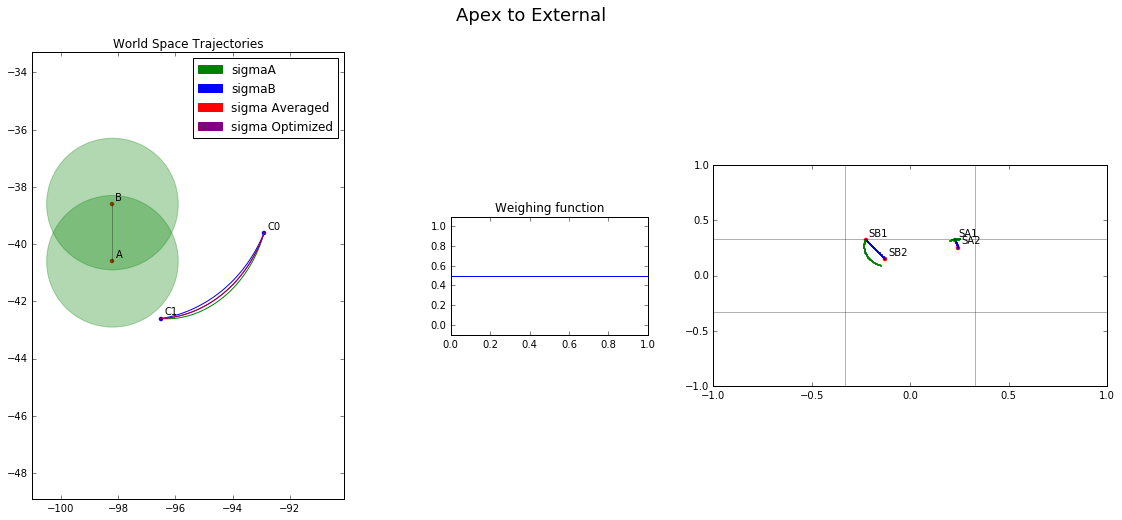

In [12]:
### # TRANSITION SETUP
#

#### Apex shot (from Unity: z,x,-y)
# Apex - new camera position: (-39.6, 0.8, -92.7) orientation (0.0, 180.0, 0.0) forward (0.0, 0.0, -1.0) up (0.0, 1.0, 0.0)
# camera specs (position, forward, up, fov)
C = np.array([-92.9,-39.6,-0.8])
fwd = np.array([-1.0,0.0,0.0])
up = np.array([0.0,0.0,-1.0])
asp = 16.0/9.0
fvY = 0.8726646

# scene specs4
PA = np.array([-98.2,-40.6,-1.6])     # person A position
PB = np.array([-98.2,-38.6,-1.6])     # person B position

SA = world_to_screen(PA, C, fwd, up, fvY, asp) # 0.220588 0.314124
SB = world_to_screen(PB, C, fwd, up, fvY, asp) # -0.220588 0.314124

### External shot (from Unity: z,x,-y)
# External - new camera position: (-42.6, 1.3, -96.5) orientation (0.0, 120.0, 0.0) forward (0.9, 0.0, -0.5) up (0.0, 1.0, 0.0)

# camera specs (position, forward, up, fov)
C_e = np.array([-96.5,-42.6,-1.3])
fwd_e = np.array([-0.5,0.9,0.0])
u_e = np.array([0.0,0.0,-1.0])

SA_e = world_to_screen(PA, C_e, fwd_e, u_e, fvY, asp) # 0.2411121 0.2592802
SB_e = world_to_screen(PB, C_e, fwd_e, u_e, fvY, asp) # -0.137811 0.1544899


camera = (C, C_e)
people = (PA, PB)
screenspace = ((SA, SB),(SA_e,SB_e))
params = {
    'min_dist':2.3, 
    'nsamples':50, 
    'fovY':fvY,
    'aspect':asp,   # Aspect scales the X axis with respect to the Y axis. AKA, "how much longer is X than Y"
    'fwd':fwd,
    'up':up,
    'figtitle':'Apex to External'
}

position_trajectories, orientation_trajectories, screen_trajectories = calculateCameraPoseTrajectory(camera, people, screenspace, params=params)
drawWorldAndScreenSpaceTrajectories(people, camera, screenspace, position_trajectories, screen_trajectories, params)

In [8]:
###
### Set up unit tests
###


In [9]:
import numpy as np 

PA = np.array([-40.6, 1.59, -98.2])
PB = np.array([-38.6, 1.59, -98.2])

#
# Camera Intrinsics
#
fwd = np.array([-1.0,0.0,0.0])
up = np.array([0.0,0.0,-1.0])
aspect = 16.0/9.0
fovY = 0.8726646 # Radians

shots = [{
    'name':"Apex Shot",
    'Camera': np.array([-39.6, 0.8, -92.7]),
    'SA': np.array([0.220588, 0.314124]),
    'SB': np.array([-0.2205887, 0.314124]),
  },{
    'name':"CloseApex Shot",
    'Camera': np.array([-39.6, 1.2, -94.2]),
    'SA': np.array([0.3015709, 0.1914706]),
    'SB': np.array([-0.3015709, 0.1914706]),
  },{
    'name':"External Shot (of A)",
    'Camera': np.array([-36.6, 1.3, -96.5]),
    'SA': np.array([0.137813, 0.1544899]),
    'SB': np.array([-0.2411098, 0.2592809]),
  },{
    'name':"External Shot (of B)",
    'Camera': np.array([-42.6, 1.3, -96.5]),
    'SA': np.array([0.2411121, 0.2592802]),
    'SB': np.array([-0.137811, 0.1544899]),
  },{
    'name':"Internal Shot (of A)",
    'Camera': np.array([-38.1, 1.5, -95.1]),
    'SA': np.array([0.07157576, 0.07157457]),
    'SB': np.array([-0.5907292, 0.100986]),
  },{
    'name':"Internal Shot (of B)",
    'Camera': np.array([-41.2, 1.5, -95.1]),
    'SA': np.array([0.5888704, 0.1016463]),
    'SB': np.array([0.07157713, 0.07157457]),
  },{
    'name':"TopDown Shot",
    'Camera': np.array([-39.6, 5.1, -95.7]),
    'SA': np.array([0.2838984, 0.2176768]),
    'SB': np.array([-0.2838984, 0.2176768]),
}]

# Convert from LHS to RHS
T_lhs_to_rhs = np.array([
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]])    

PA = T_lhs_to_rhs.dot(PA)
PB = T_lhs_to_rhs.dot(PB)

for s in shots:
    v = s['Camera']
    print T_lhs_to_rhs.dot(v) 
    
    s['Camera'] = T_lhs_to_rhs.dot(v)
        

[-39.6 -92.7   0.8]
[-39.6 -94.2   1.2]
[-36.6 -96.5   1.3]
[-42.6 -96.5   1.3]
[-38.1 -95.1   1.5]
[-41.2 -95.1   1.5]
[-39.6 -95.7   5.1]


  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5021s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5066s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5209s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5091s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determin

/Users/njoubert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


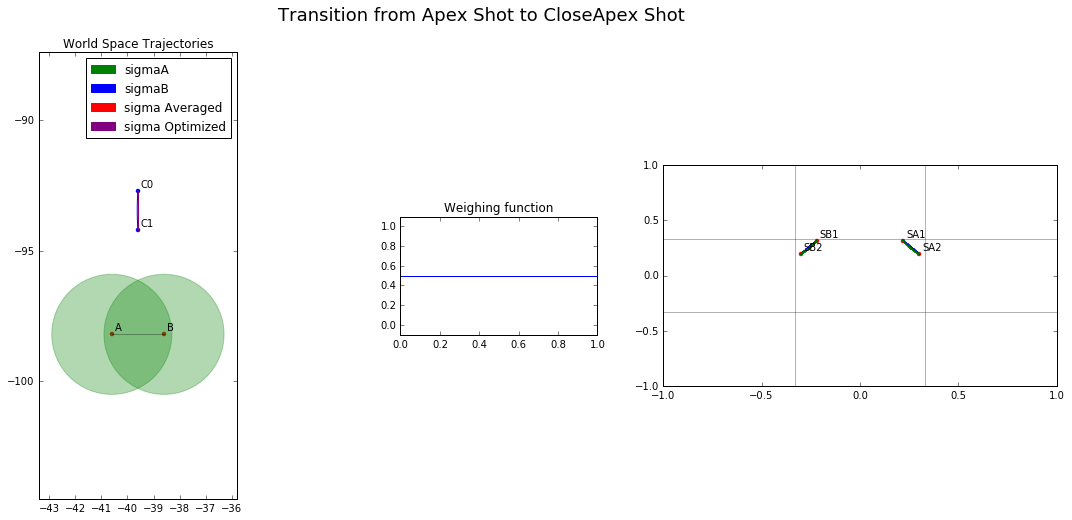

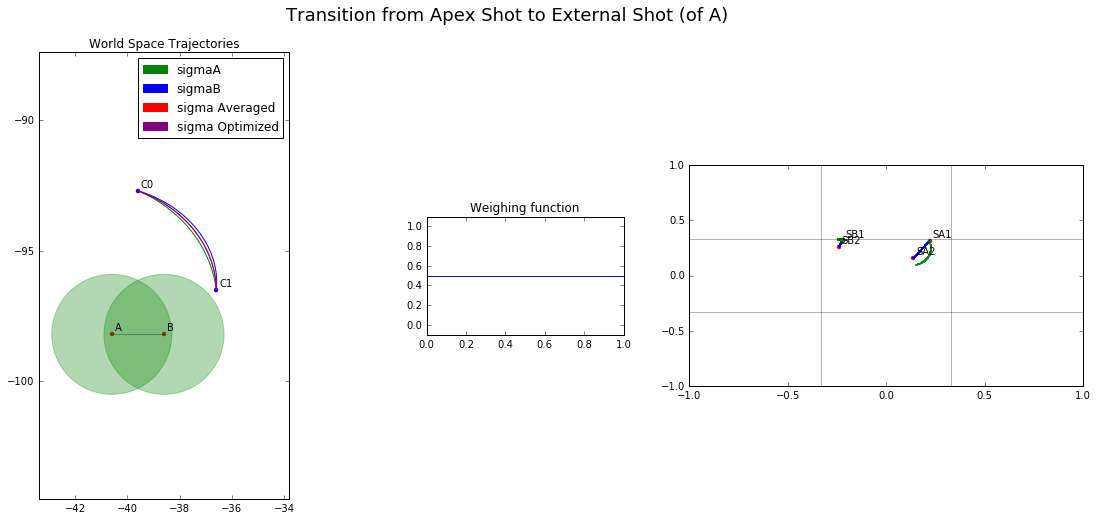

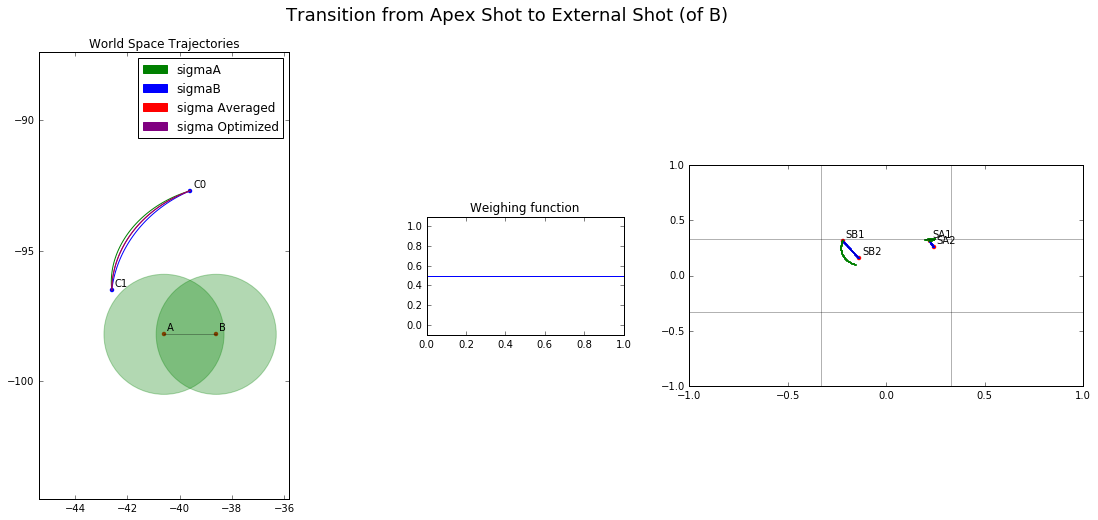

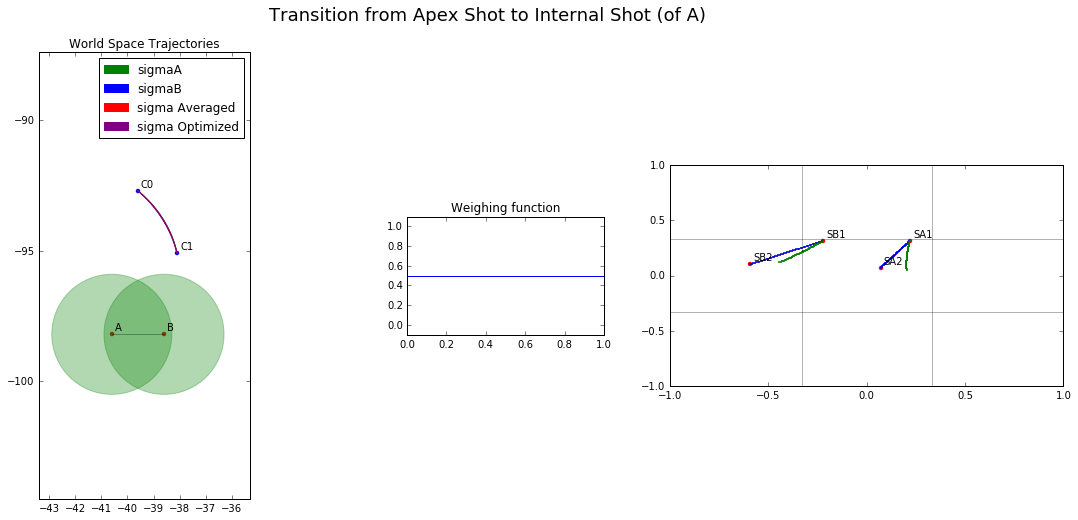

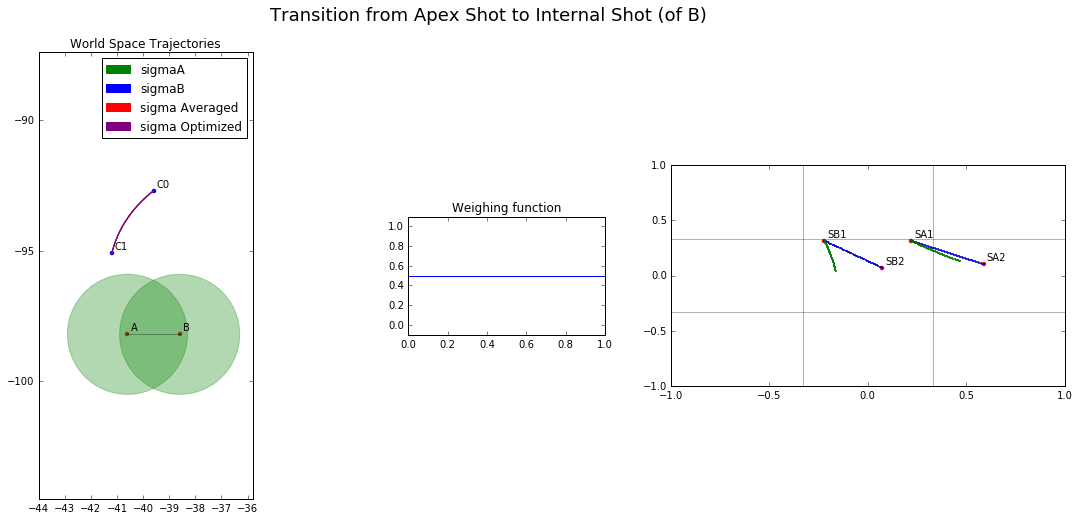

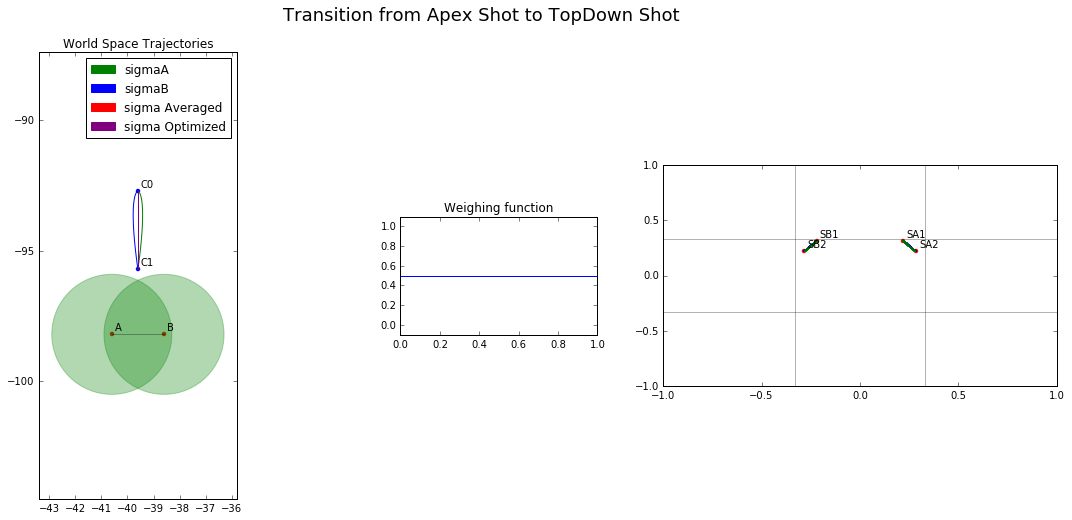

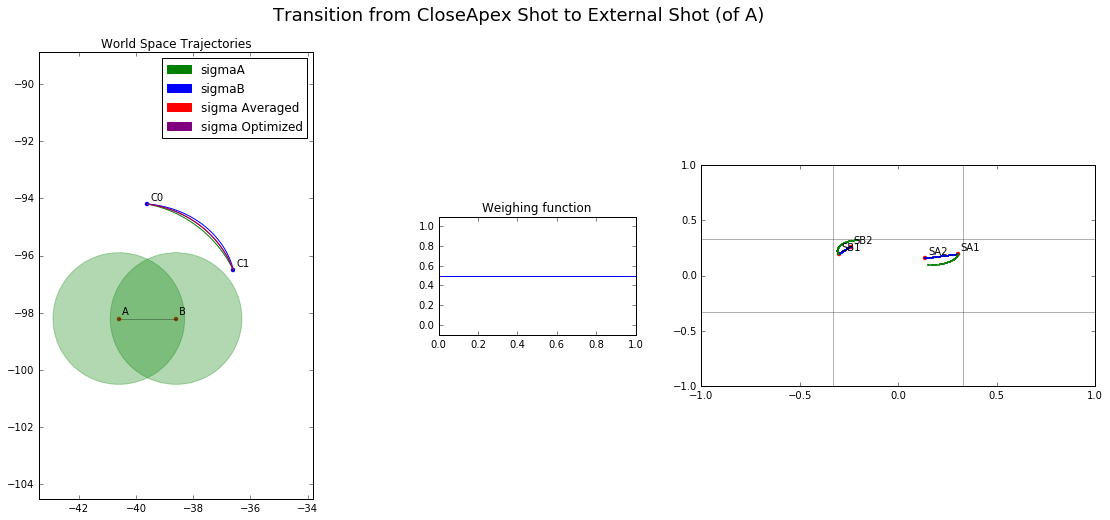

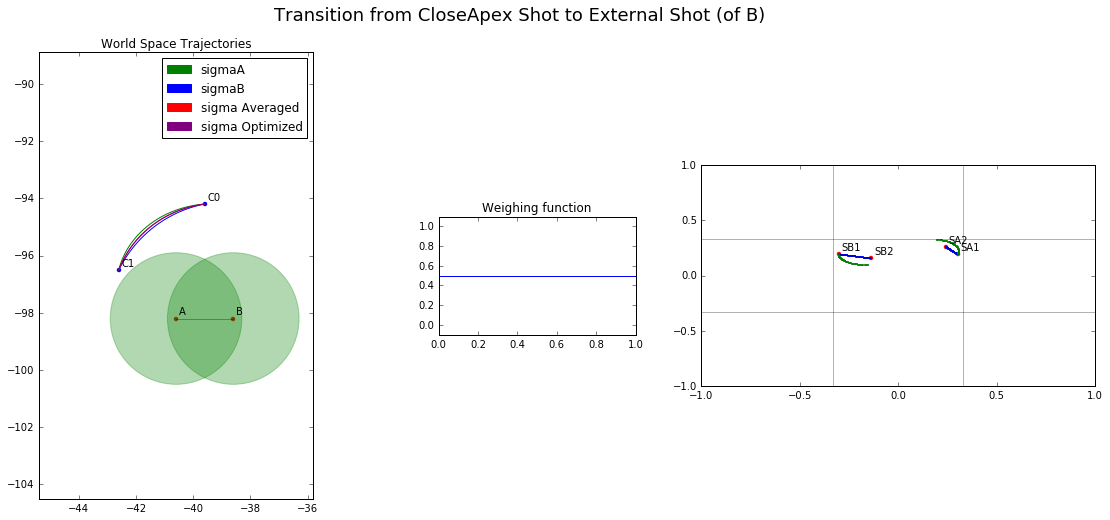

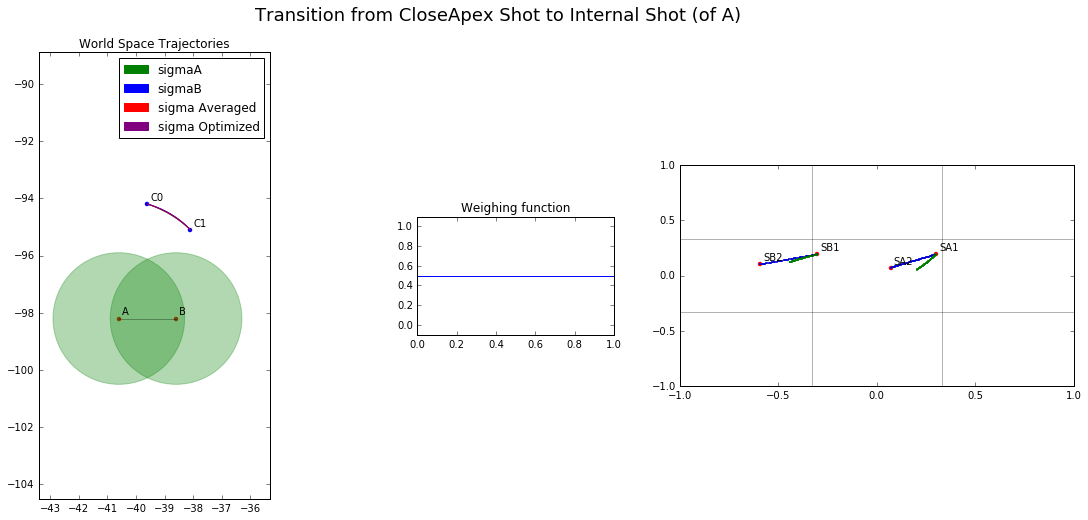

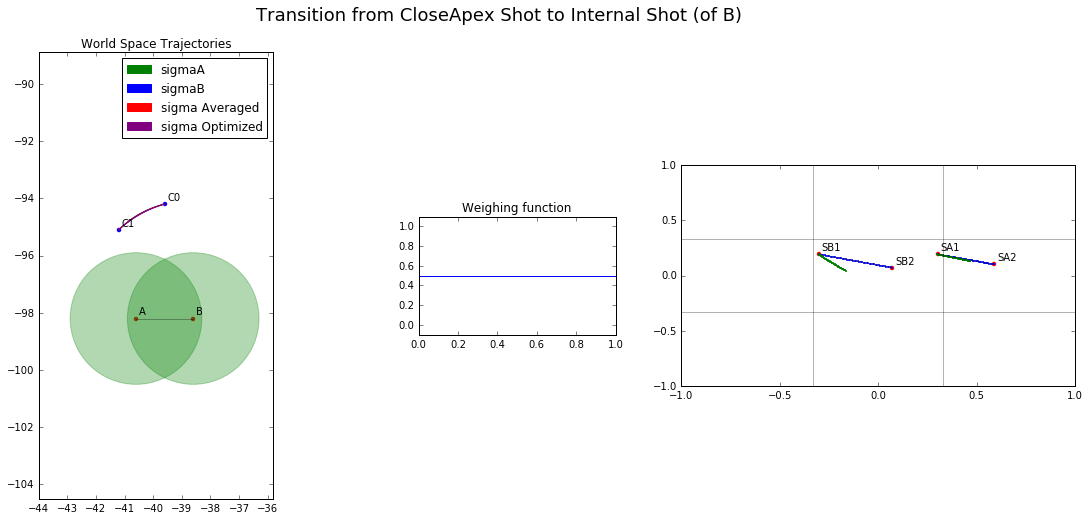

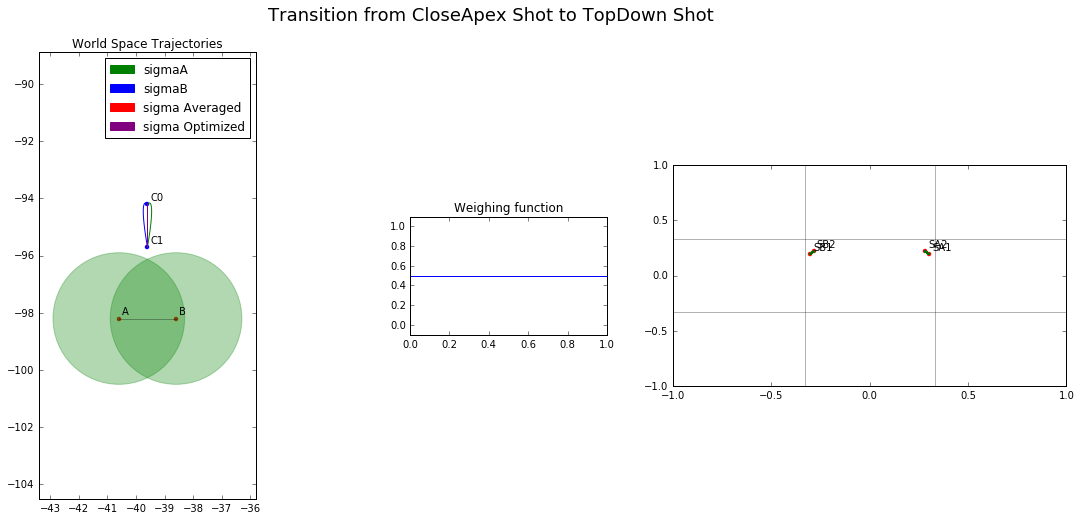

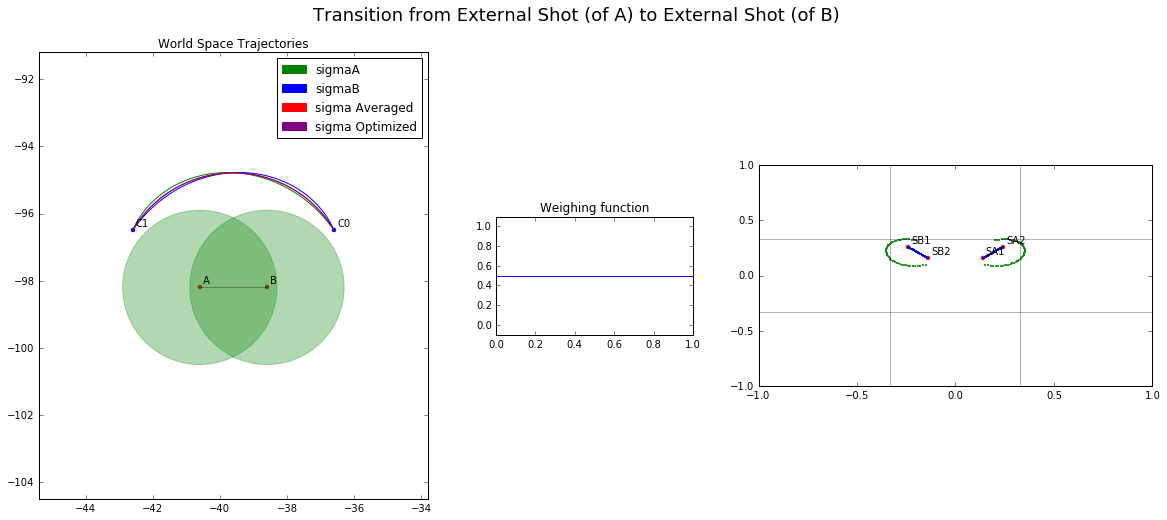

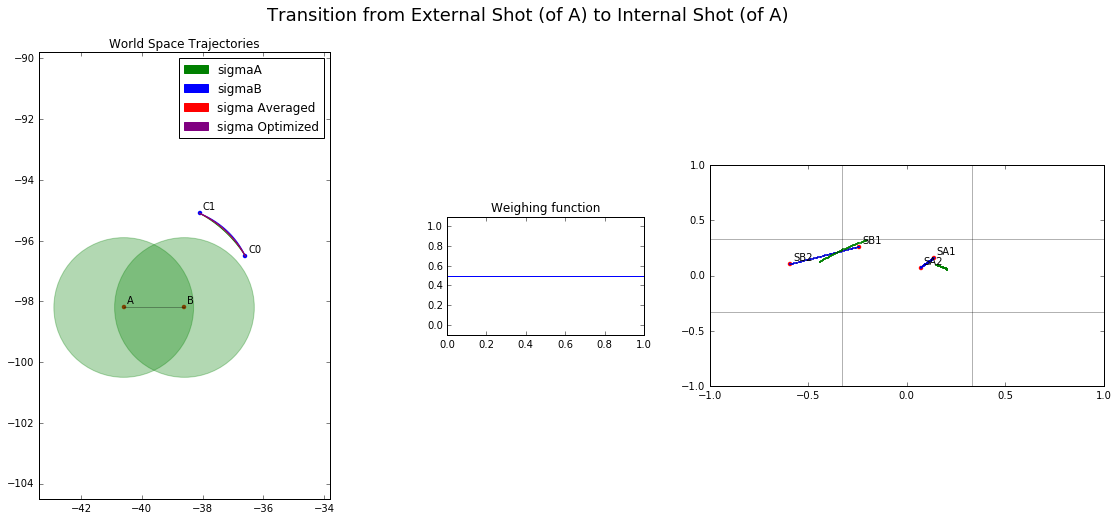

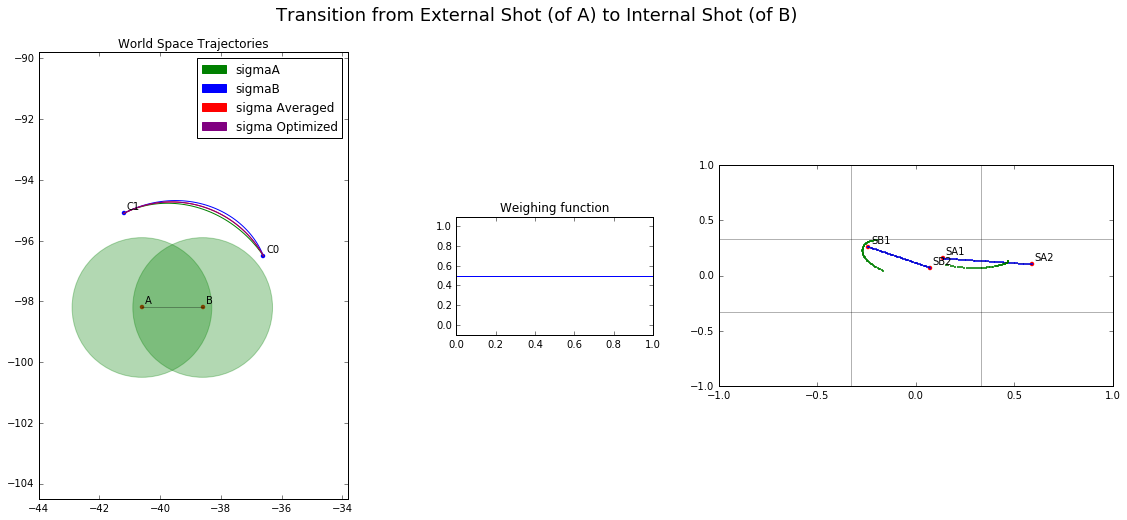

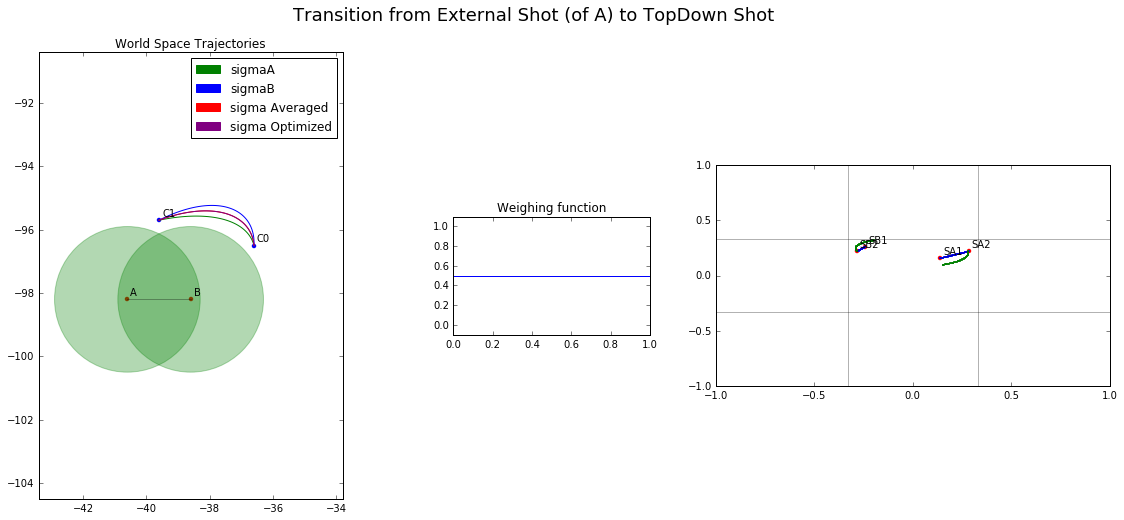

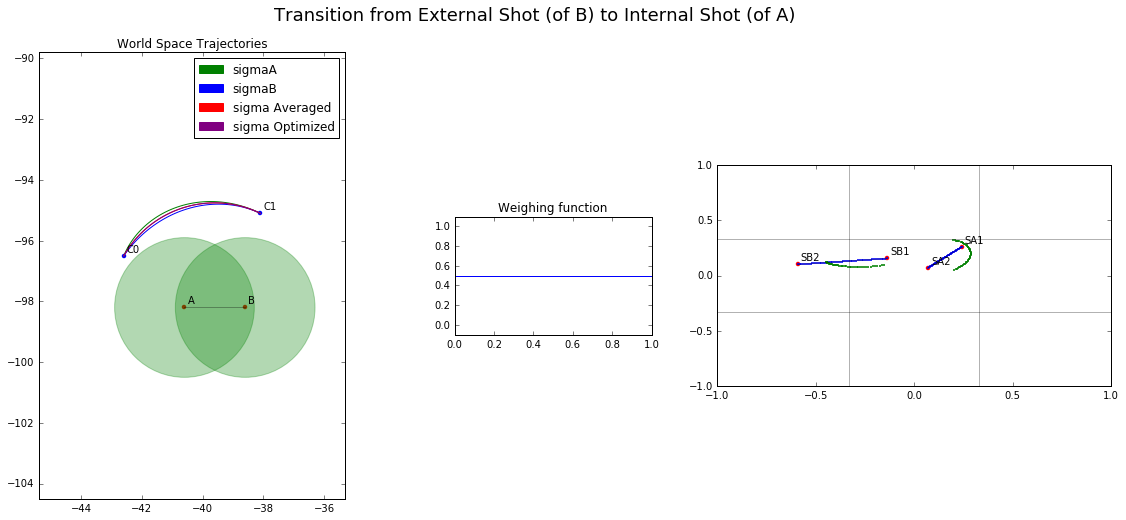

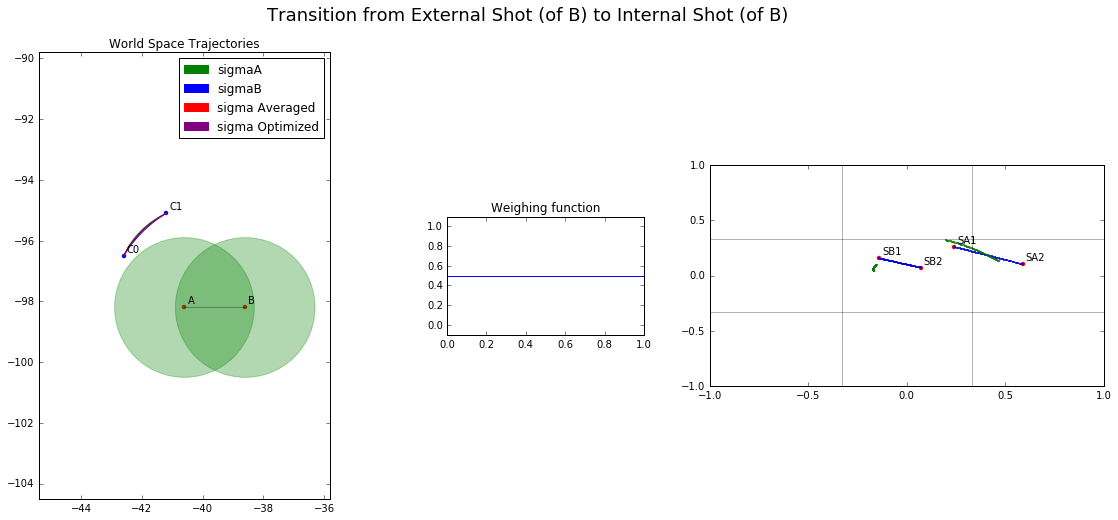

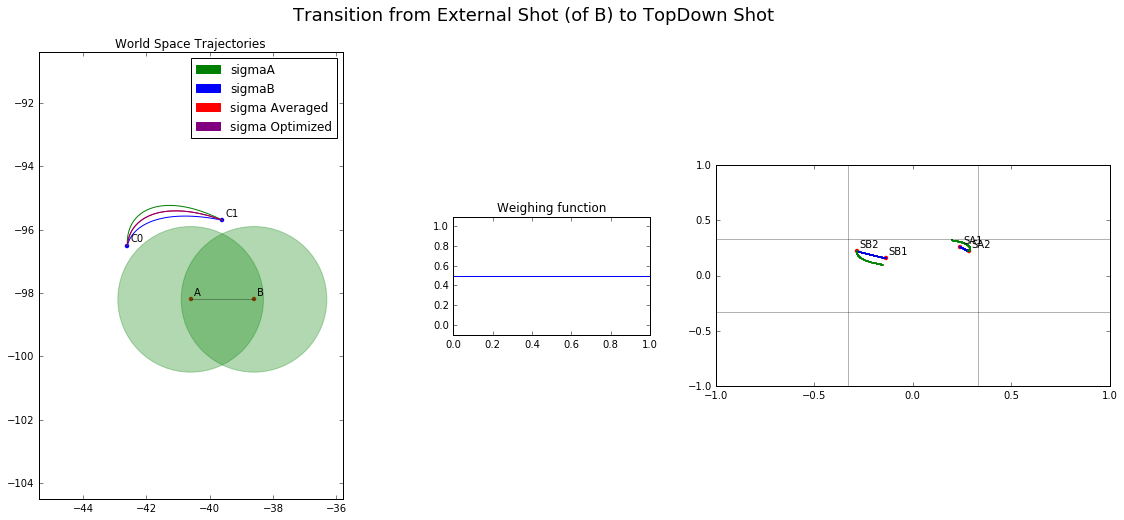

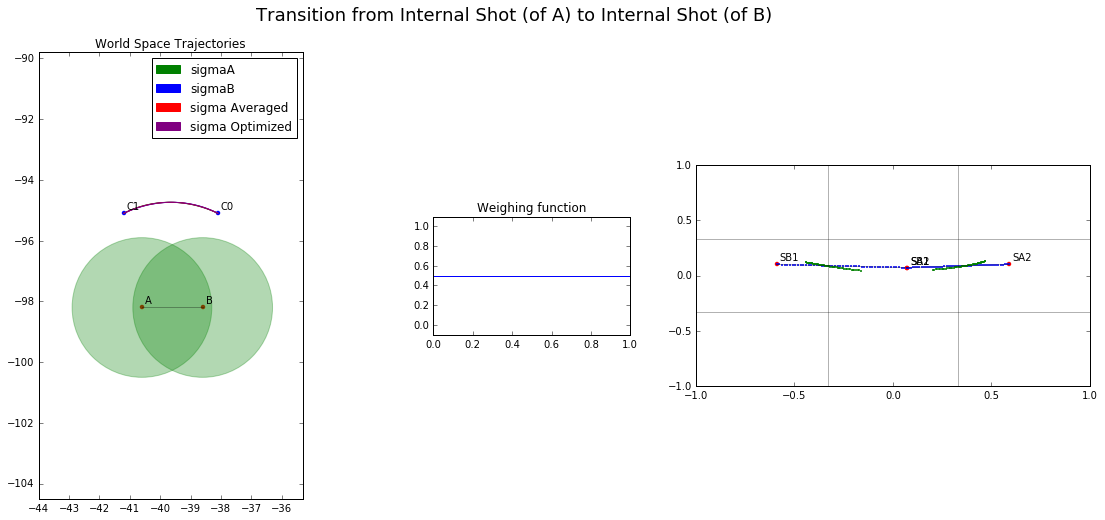

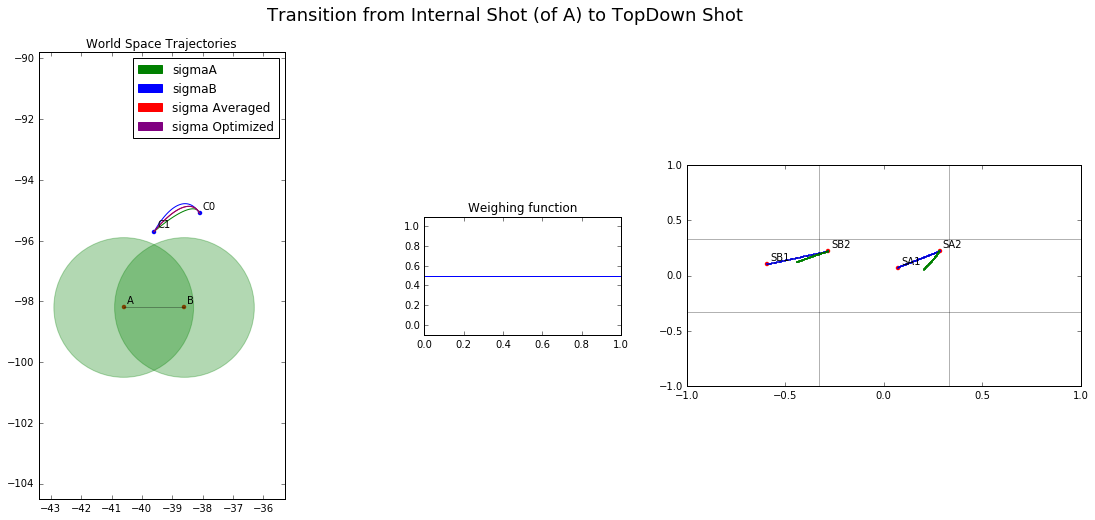

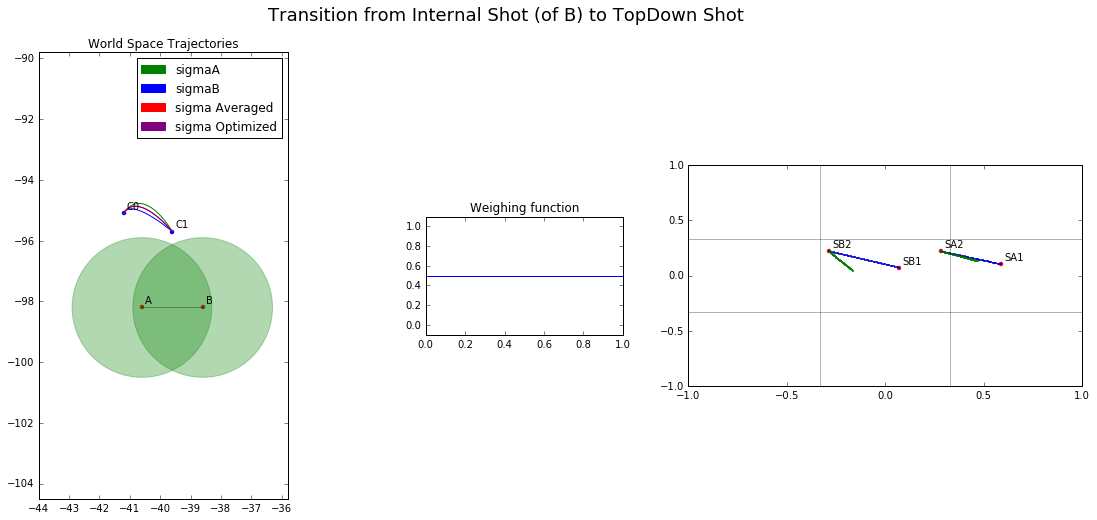

In [10]:
for i in range(len(shots)):
    for j in range(i+1, len(shots)):
        shotA = shots[i]
        shotB = shots[j]
        
            
        camera = (shotA['Camera'], shotB['Camera'])
        people = (PA, PB)
        screenspace = ((shotA['SA'], shotA['SB']),(shotB['SA'], shotB['SB']))
        params = {
            'min_dist':2.3, 
            'nsamples':50, 
            'fovY':fvY,
            'aspect':asp,   # Aspect scales the X axis with respect to the Y axis. AKA, "how much longer is X than Y"
            'fwd':fwd,
            'up':up,
            'figtitle':"Transition from %s to %s" % (shotA['name'],shotB['name'])
        }

        position_trajectories, orientation_trajectories, screen_trajectories = calculateCameraPoseTrajectory(camera, people, screenspace, params=params)
        drawWorldAndScreenSpaceTrajectories(people, camera, screenspace, position_trajectories, screen_trajectories, params)


[-39.6       -92.73151     0.7856504]
[-39.6     -95.76184   1.22953]
[-39.6      -96.00198    4.531153]
[-36.66464  -96.61747    1.235261]
[-42.53536  -96.61747    1.235261]
[-39.36054  -95.81849    1.453164]
[-39.96825  -95.78114    1.453164]
  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.4980s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5111s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5002s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000
  Could not determin

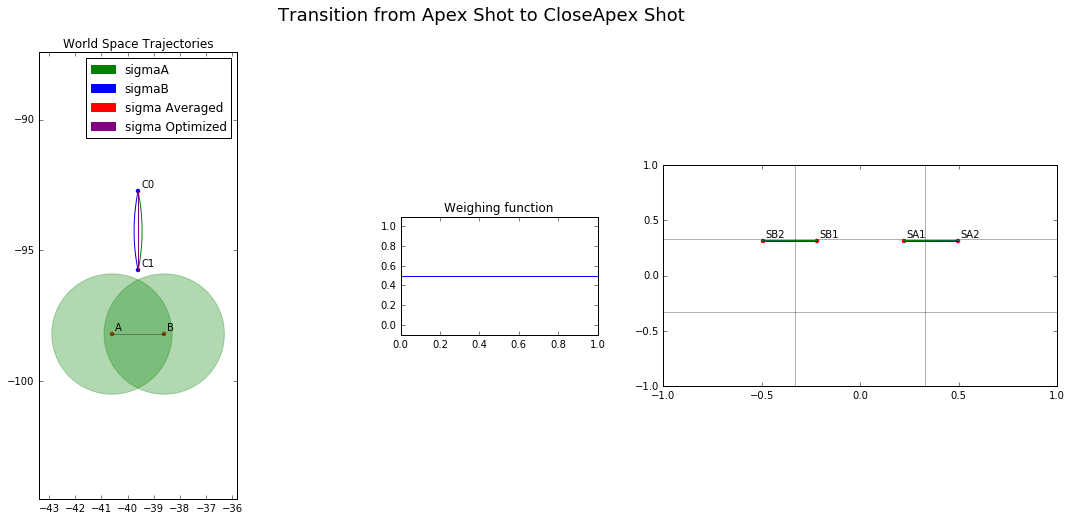

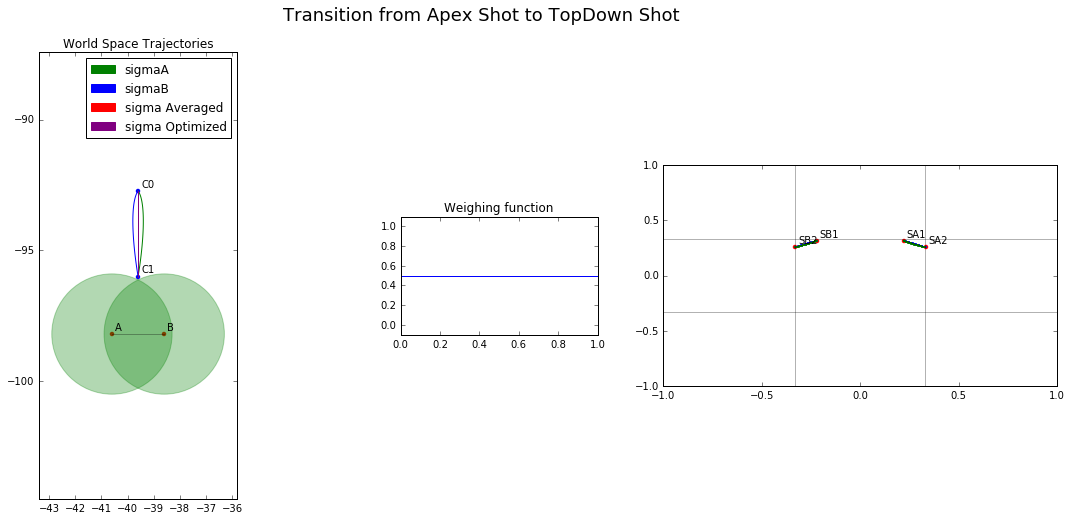

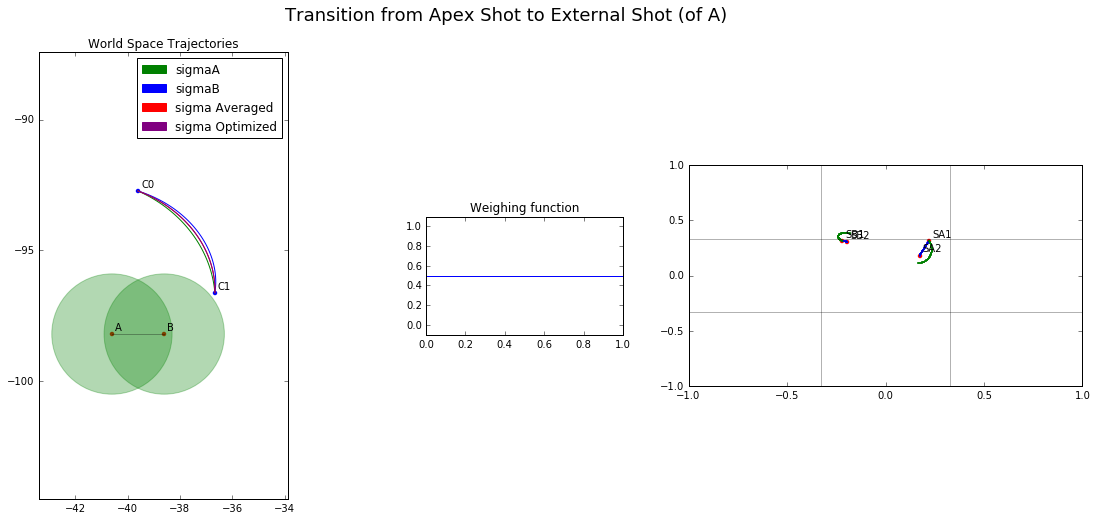

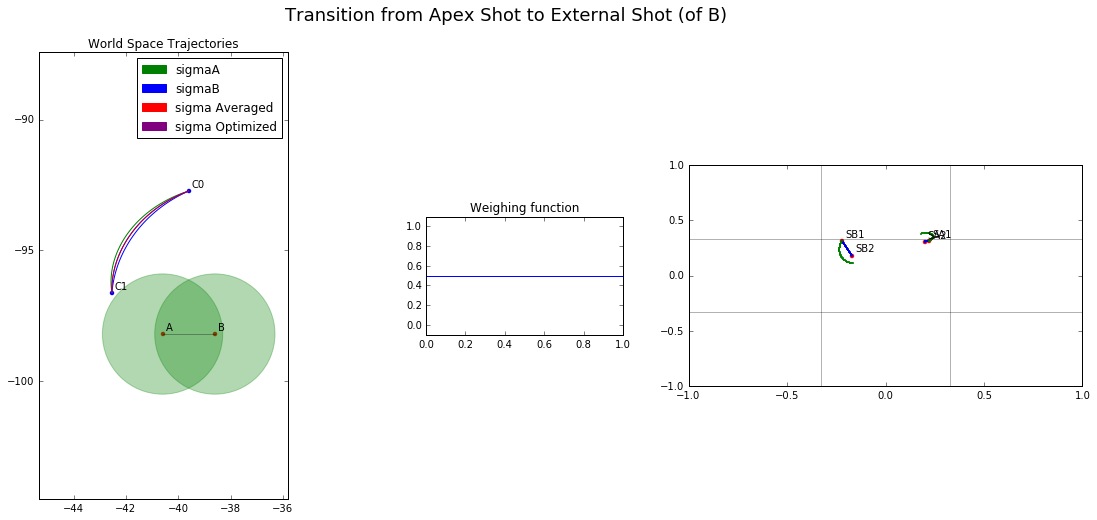

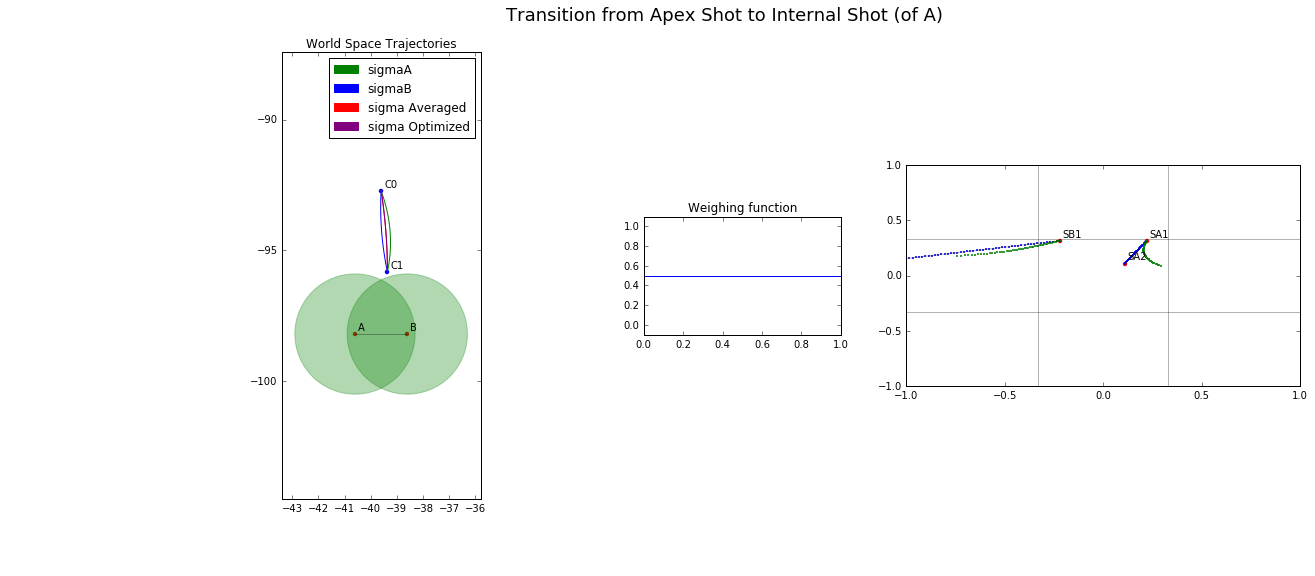

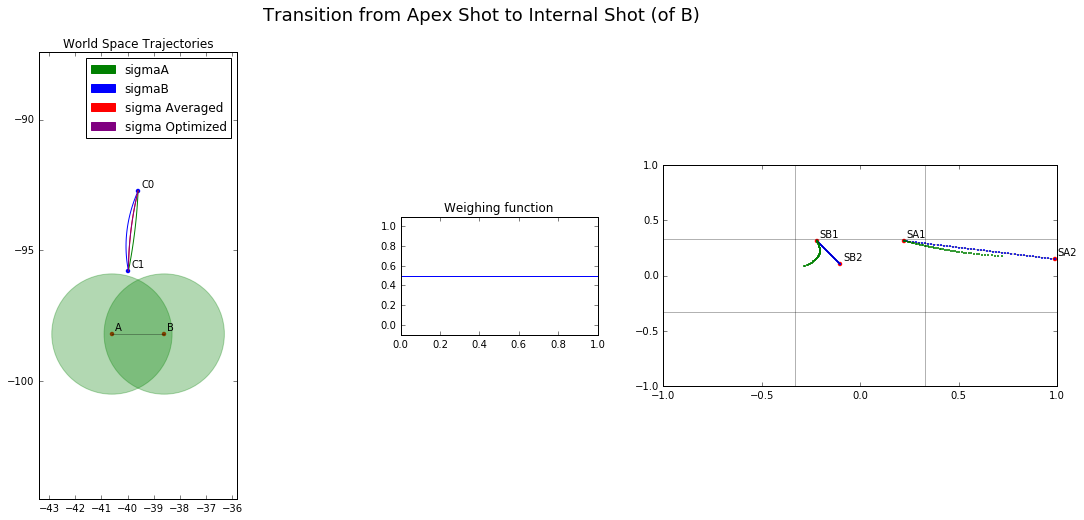

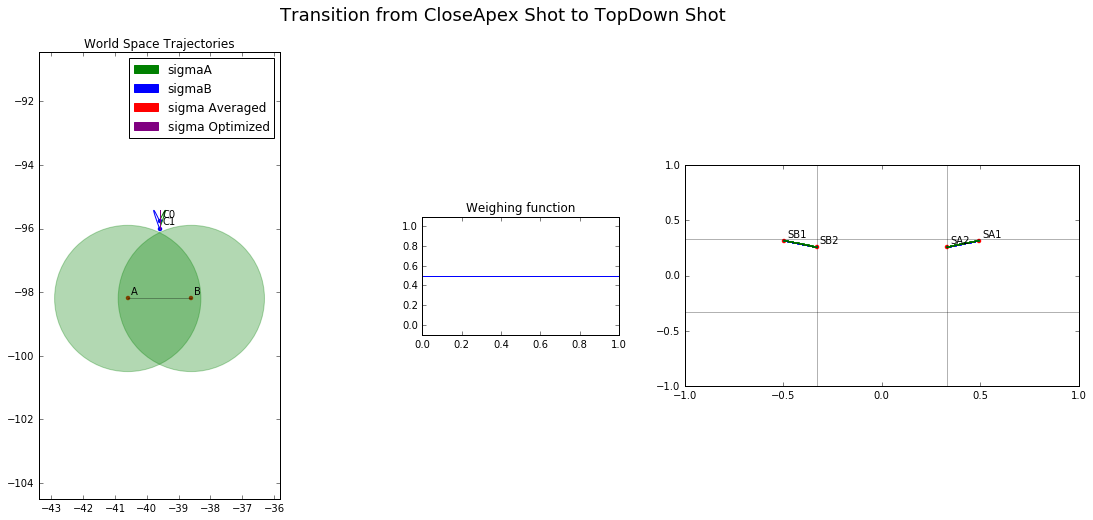

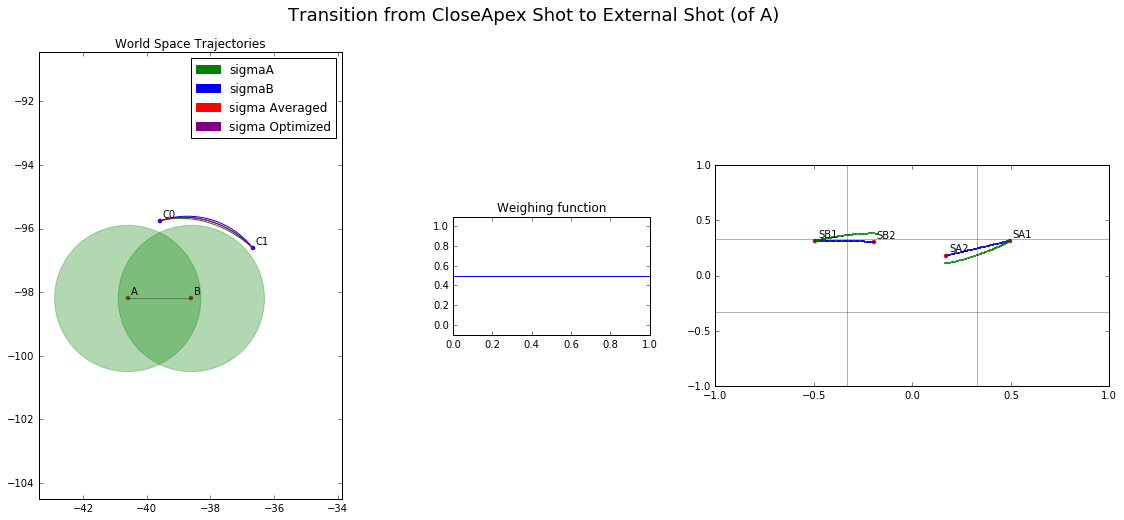

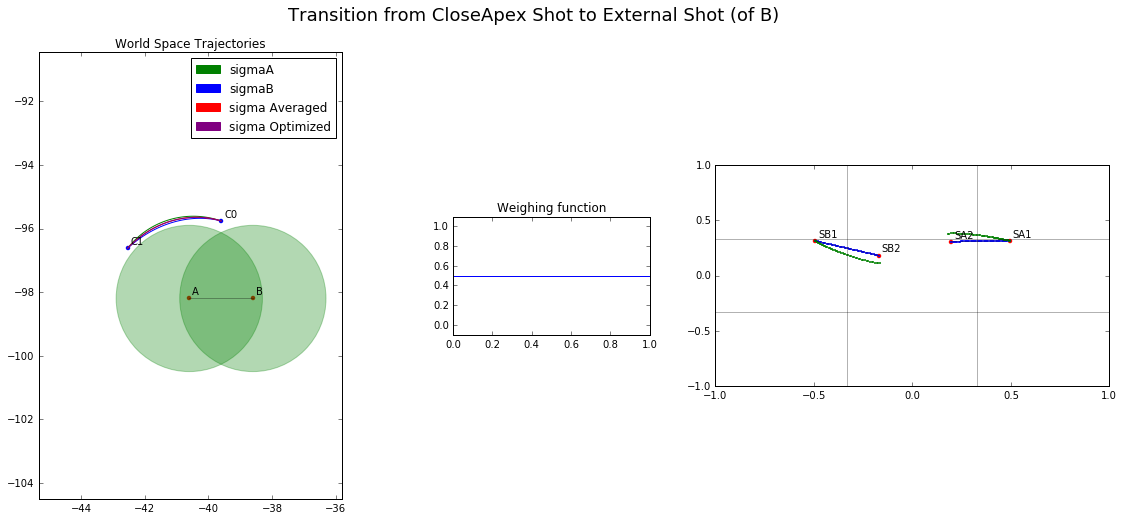

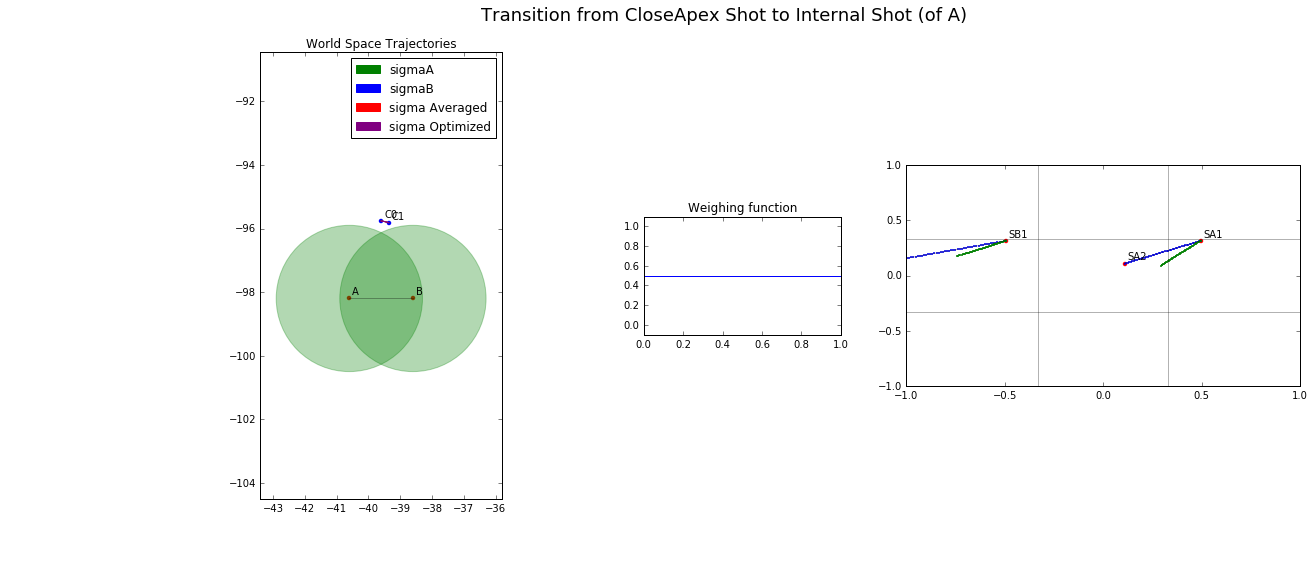

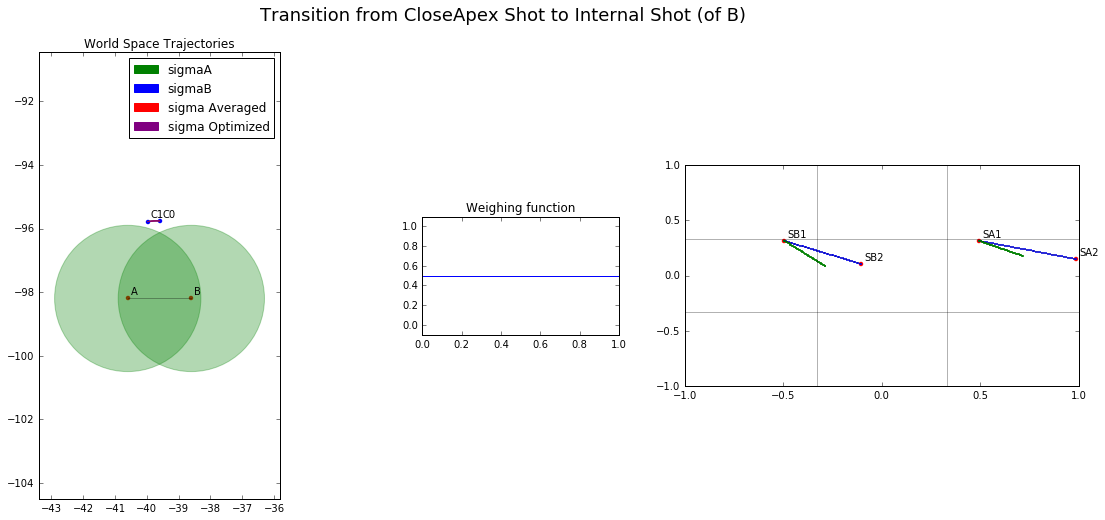

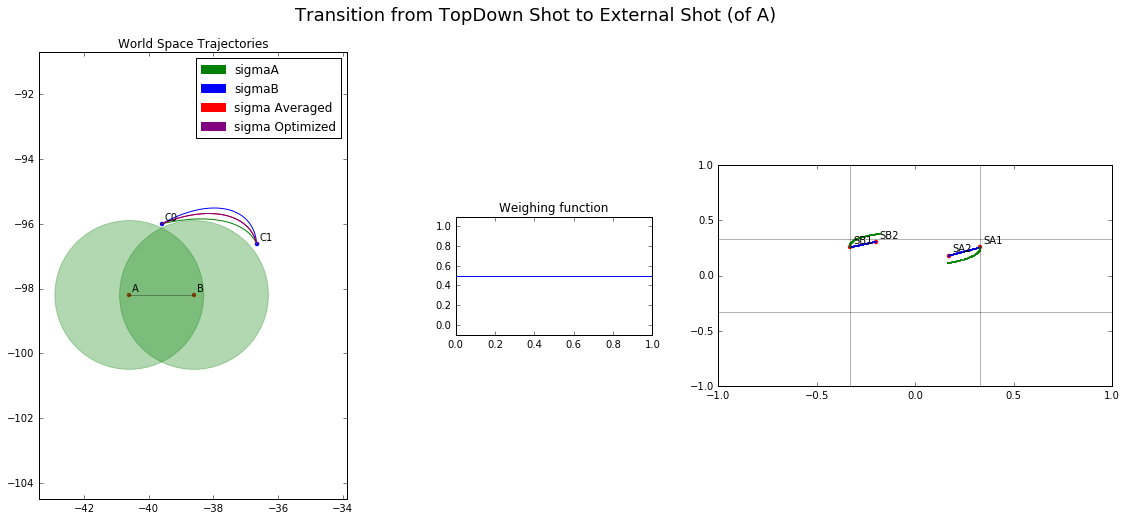

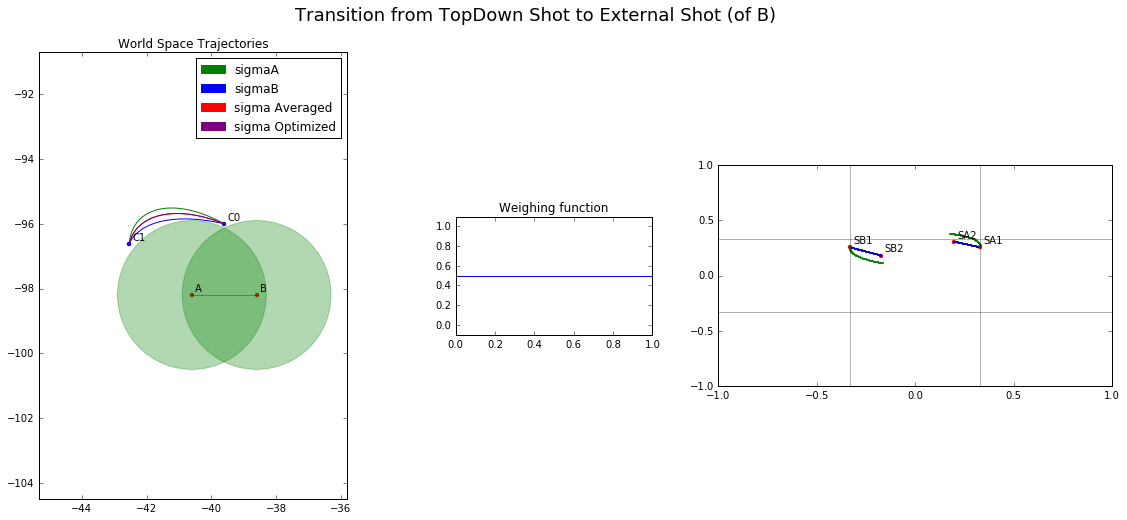

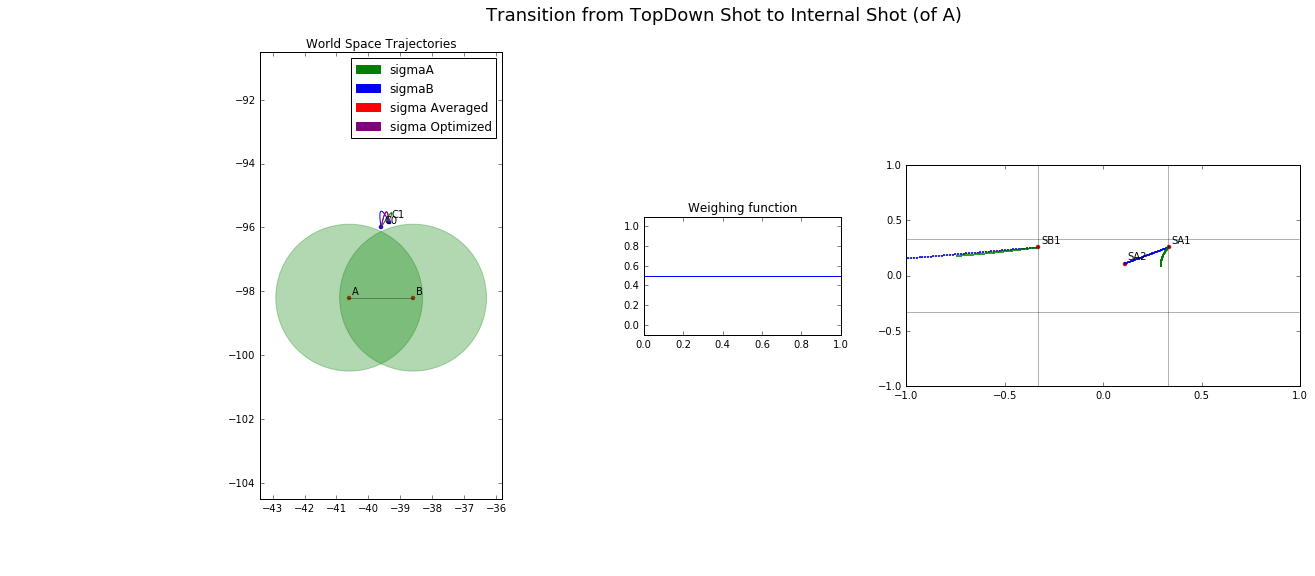

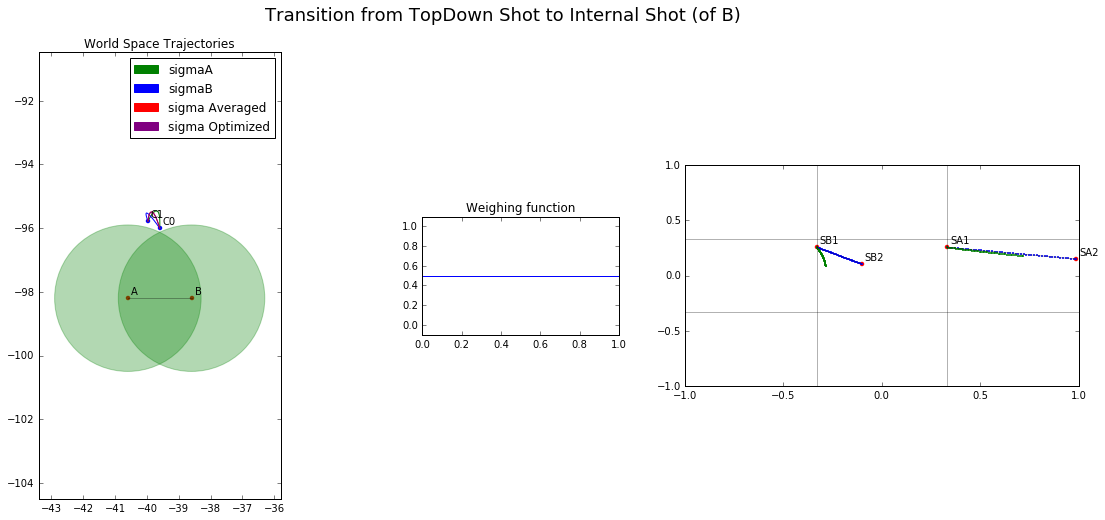

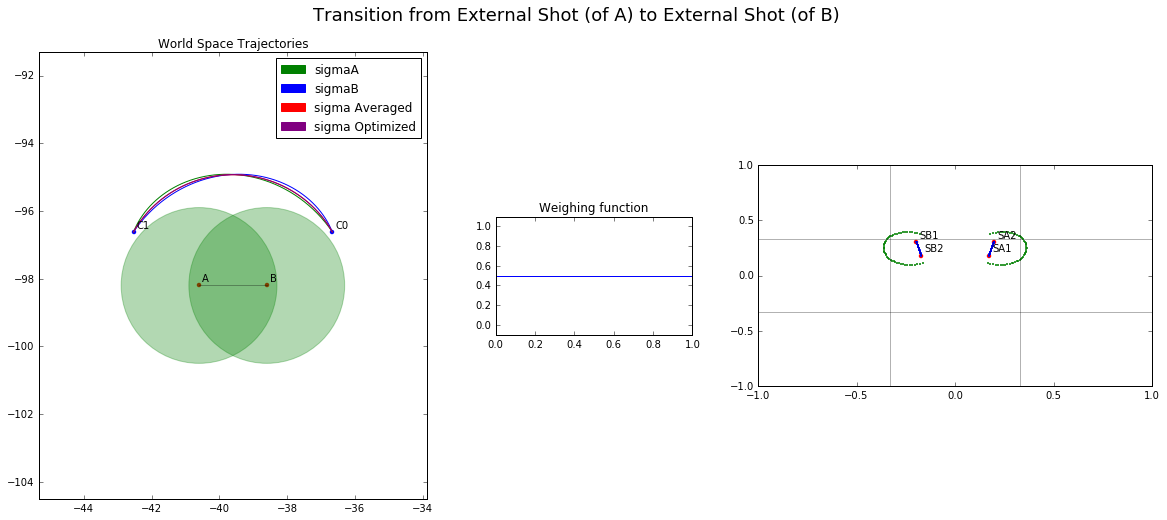

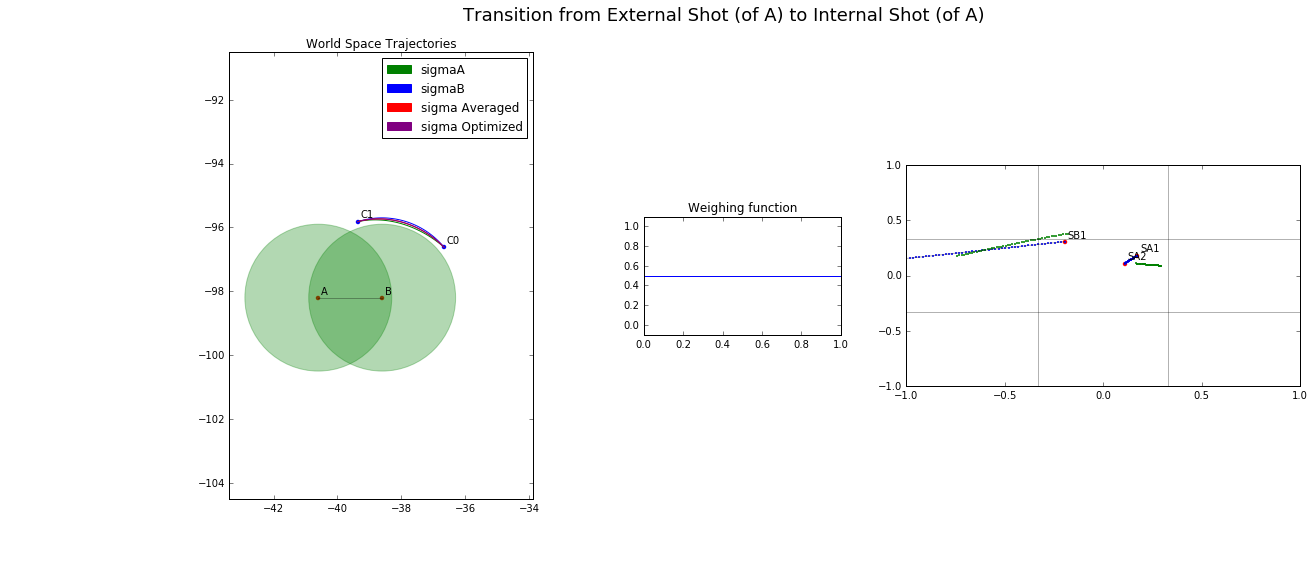

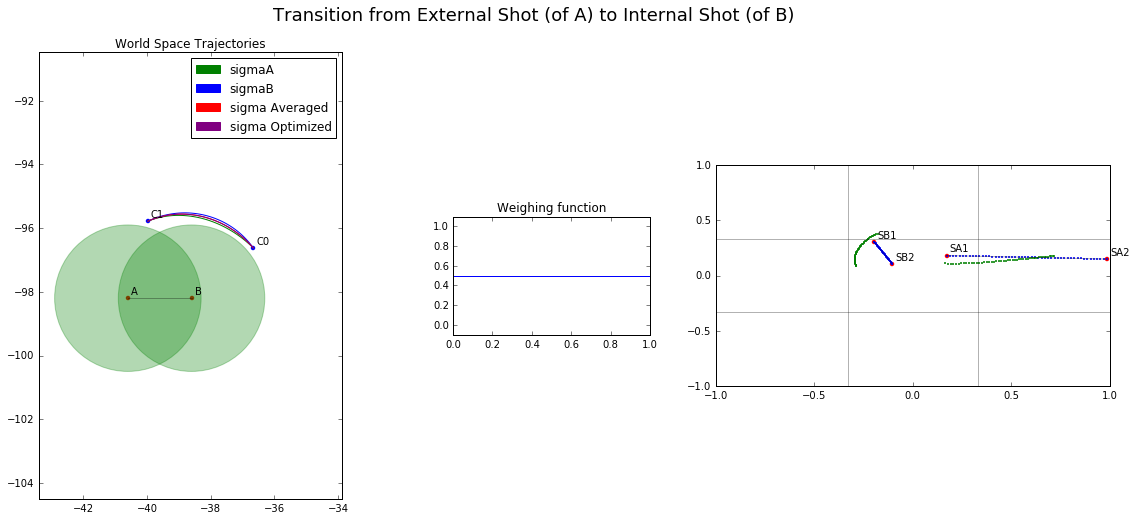

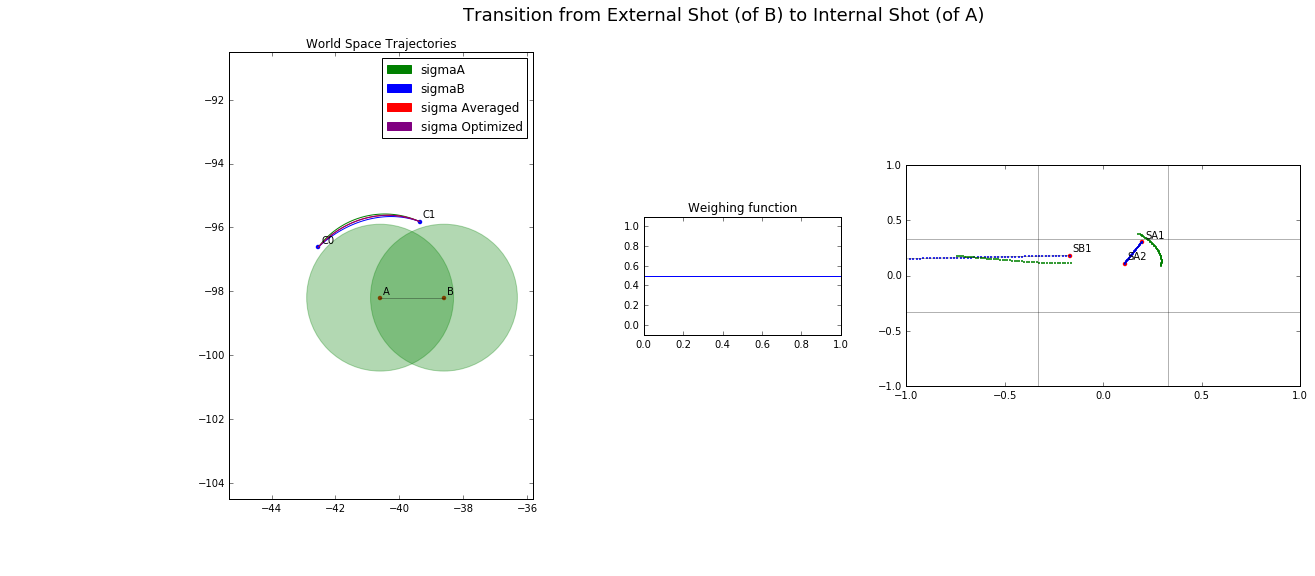

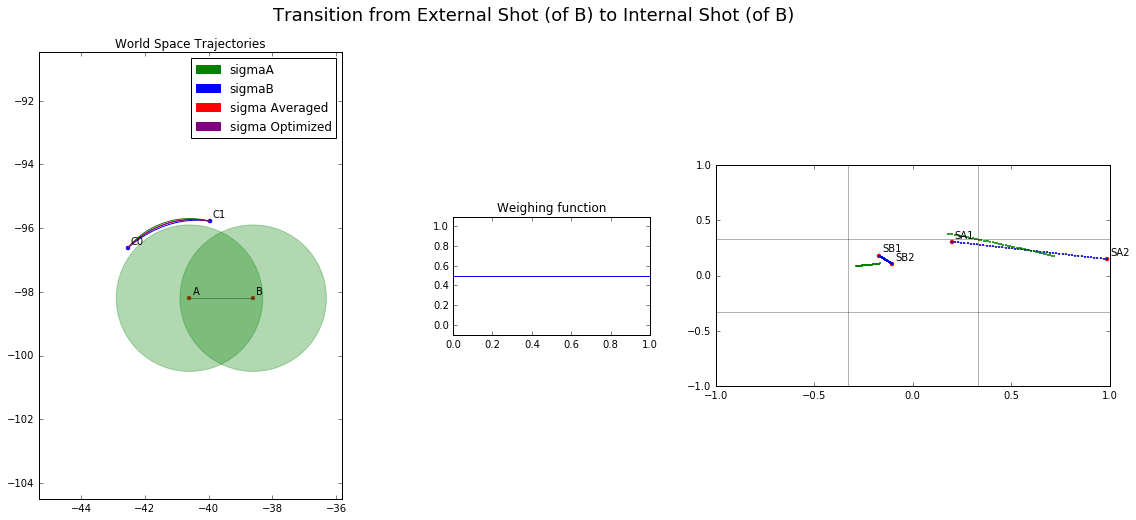

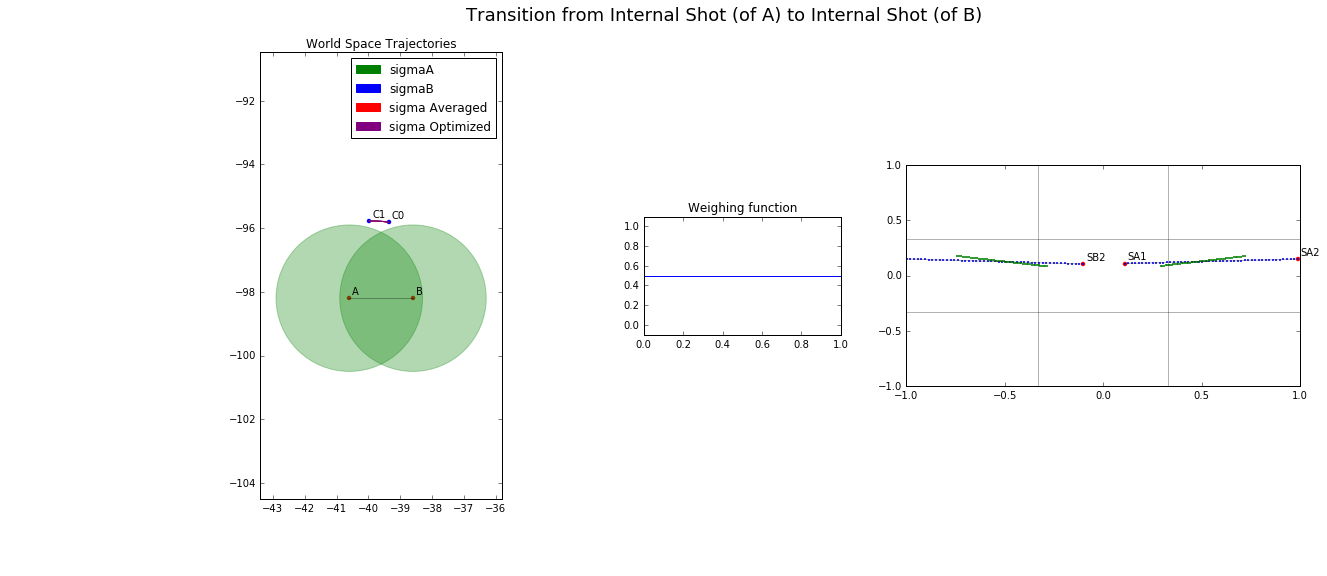

In [13]:
import numpy as np 

PA = np.array([-40.6, 1.586667, -98.2])
PB = np.array([-38.6, 1.586667, -98.2])

#
# Camera Intrinsics
#
fwd = np.array([-1.0,0.0,0.0])
up = np.array([0.0,0.0,-1.0])
aspect = 16.0/9.0
fovY = 0.8726646 # Radians

shots = [{
  'Name':"Apex Shot",
  'Camera':np.array([-39.6, 0.7856504, -92.73151]),
  'Orientation':np.array([0.5017827, 180, 1.908406E-14]),
  'scale':1,
  'SA':np.array([0.220588, 0.314124]),
  'SB':np.array([-0.2205887, 0.314124]),
},{
  'Name':"CloseApex Shot",
  'Camera':np.array([-39.6, 1.22953, -95.76184]),
  'Orientation':np.array([0.501792, 180, 3.816812E-14]),
  'scale':1,
  'SA':np.array([0.4947524, 0.3141237]),
  'SB':np.array([-0.494754, 0.3141237]),
},{
  'Name':"TopDown Shot",
  'Camera':np.array([-39.6, 4.531153, -96.00198]),
  'Orientation':np.array([62.09423, 179.9082, 7.125894E-09]),
  'scale':1,
  'SA':np.array([0.3318715, 0.2547585]),
  'SB':np.array([-0.3299288, 0.2547585]),
},{
  'Name':"External Shot (of A)",
  'Camera':np.array([-36.66464, 1.235261, -96.61747]),
  'Orientation':np.array([359.8232, 239.9469, 0]),
  'scale':0.518039,
  'SA':np.array([0.1726797, 0.1808698]),
  'SB':np.array([-0.1961596, 0.3066275]),
},{
  'Name':"External Shot (of B)",
  'Camera':np.array([-42.53536, 1.235261, -96.61747]),
  'Orientation':np.array([359.7736, 119.9626, 6.670158E-09]),
  'scale':0.5122025,
  'SA':np.array([0.1981061, 0.3066272]),
  'SB':np.array([-0.1707342, 0.1808698]),
},{
  'Name':"Internal Shot (of A)",
  'Camera':np.array([-39.36054, 1.453164, -95.81849]),
  'Orientation':np.array([0.02811415, 202.3725, 4.168817E-10]),
  'scale':0.3243892,
  'SA':np.array([0.1081297, 0.1086004]),
  'SB':np.array([-1.017039, 0.1512574]),
},{
  'Name':"Internal Shot (of B)",
  'Camera':np.array([-39.96825, 1.453164, -95.78114]),
  'Orientation':np.array([359.9772, 155.3631, -4.168817E-10]),
  'scale':0.3075859,
  'SA':np.array([0.986918, 0.1493192]),
  'SB':np.array([-0.1025286, 0.1049473]),
}]



### camera positions:

# Convert from LHS to RHS
T_lhs_to_rhs = np.array([
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]])    

PA = T_lhs_to_rhs.dot(PA)
PB = T_lhs_to_rhs.dot(PB)

for s in shots:
    v = s['Camera']
    print T_lhs_to_rhs.dot(v) 
    
    s['Camera'] = T_lhs_to_rhs.dot(v)
    
for i in range(len(shots)):
    for j in range(i+1, len(shots)):
        shotA = shots[i]
        shotB = shots[j]
        
            
        camera = (shotA['Camera'], shotB['Camera'])
        people = (PA, PB)
        screenspace = ((shotA['SA'], shotA['SB']),(shotB['SA'], shotB['SB']))
        params = {
            'min_dist':2.3, 
            'nsamples':50, 
            'fovY':fvY,
            'aspect':asp,   # Aspect scales the X axis with respect to the Y axis. AKA, "how much longer is X than Y"
            'fwd':fwd,
            'up':up,
            'figtitle':"Transition from %s to %s" % (shotA['Name'],shotB['Name'])
        }

        position_trajectories, orientation_trajectories, screen_trajectories = calculateCameraPoseTrajectory(camera, people, screenspace, params=params)
        drawWorldAndScreenSpaceTrajectories(people, camera, screenspace, position_trajectories, screen_trajectories, params)


## Plotting in 3D

  Could not determine Jacobian structure from user input
  Calling snJac...
Solved in 0.5730s
Value of objective function: 0.00000000
   lambda_pos: 1.000000, lambda_snap: 1.000000, 
   objective: 0.000000, obj_pos: 0.000000, obj_snap: 0.000000


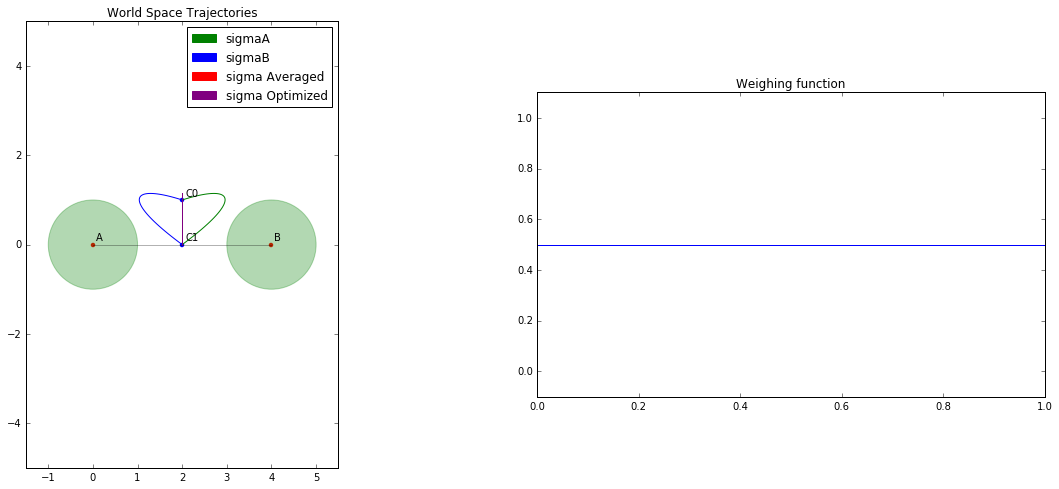

In [10]:

PA = np.array([0, 0, 0])
PB = np.array([4, 0, 0])
C0 = np.array([2, 1, 0])
C1 = np.array([2, 0, 5])
min_dist = 1

params = {
    'min_dist':1, 
    'nsamples':50, 
    'fovY':fvY,
    'aspect':asp,   # Aspect scales the X axis with respect to the Y axis. AKA, "how much longer is X than Y"
    'fwd':fwd,
    'up':up
}

position_trajectories = calculate_position_trajectory_as_optimized_blend(
    PA, PB, C0, C1, real_optimizer_unconstrained_at_endpoints, params)

sigma, wA, sigmaAvg, sigmaA, sigmaB = position_trajectories

drawWorldTrajectory((PA, PB), (C0, C1), position_trajectories, params)
    

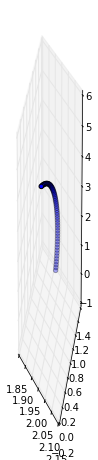

In [11]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

ax.scatter(sigma[:,0],sigma[:,1],sigma[:,2])